In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt

In [4]:
BASE_PATH = "/data/saturation/thesis_run_20250223/"

# Simulation IDs for the training set
MIN_SIMULATION_ID = 1
MAX_SIMULATION_ID = 150
simulation_ids = list(range(MIN_SIMULATION_ID, MAX_SIMULATION_ID + 1))

N_NSTATS = 100

FONT_SIZE = 22
DPI = 400
IMAGE_TYPE = "svg"

In [42]:
n_cores = 26

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "40g")
    .config("spark.driver.maxResultSize", "16g")
    .getOrCreate()
)

25/04/15 23:15:36 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/04/15 23:15:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 23:15:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [140]:
def plot_dsfds(
    diameters_list,
    edf_diam_list,
    edf_dsfd_list,
    edf_erro_dsfd_neg_list,
    edf_erro_dsfd_pos_list,
    edf_erro_dsfd_neg_1s_list,
    edf_erro_dsfd_pos_1s_list,
    labels,
    colors
):
    DSFDWindow = plt.figure(1, figsize=(12,8))
    DSFD = DSFDWindow.add_subplot(111)

    n_plots = len(edf_diam_list)

    for n in range(n_plots):
        diameters = diameters_list[n]
        edf_diam = edf_diam_list[n]
        edf_dsfd = edf_dsfd_list[n]
        edf_erro_dsfd_neg = edf_erro_dsfd_neg_list[n]
        edf_erro_dsfd_pos = edf_erro_dsfd_pos_list[n]
        edf_erro_dsfd_neg_1s = edf_erro_dsfd_neg_1s_list[n]
        edf_erro_dsfd_pos_1s = edf_erro_dsfd_pos_1s_list[n]
        label = labels[n]
        color = colors[n]
        
        #To the plot, append the trace.
        DSFD.plot(edf_diam, edf_dsfd, color='#D53200', linewidth=1, label=label)
        DSFD.fill_between(edf_diam,edf_erro_dsfd_neg,edf_erro_dsfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor=color)
        DSFD.plot(edf_diam, edf_erro_dsfd_neg_1s, color='#D53200', linewidth=0.25)
        DSFD.plot(edf_diam, edf_erro_dsfd_pos_1s, color='#D53200', linewidth=0.25)
    
        #Append the legend to the plot.
        DSFD.legend(loc='upper right')
    
        #Set the x-y range to the plot.
        DSFD.set_xlim(np.power(10,np.floor(np.log10(min(diameters)))), np.power(10,np.ceil(np.log10(max(diameters)))))
        start = find_nearest(edf_diam,min(diameters))
        stop  = find_nearest(edf_diam,max(diameters))
        y_min = min(edf_dsfd[start:stop])
        y_max = edf_erro_dsfd_pos[np.where(edf_dsfd == max(edf_dsfd[start:stop]))]
        DSFD.set_ylim(y_min,y_max)
    
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        DSFD.plot(diameters, np.full(len(diameters),y_min), '|r')
    
        #Make the x-y axes log.
        DSFD.set_xscale('log')
        DSFD.set_yscale('log')
    
        #Turn on grid lines.
        DSFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
        DSFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)

# Load Data

In [151]:
configs_df = read_configs_pandas(base_path=BASE_PATH)
configs_dict = configs_df.set_index("simulation_id").to_dict(orient="index")

In [152]:
configs_df[configs_df.slope == -4.5]

,calculate_areal_density,calculate_nearest_neighbor_stats,initial_rim_calculation_method,mrp,random_seed,rim_erasure_method,rmax,rmin,rmult,rstat,...,spatial_hash_cell_size,stop_condition,study_region_padding,study_region_size,write_crater_removals_cadence,write_craters_cadence,write_image_cadence,write_image_points,write_state_cadence,write_statistics_cadence
70,False,False,{'name': 'circumference'},0.5,1228959103,"{'exponent': 0.3, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
71,False,False,{'name': 'circumference'},0.5,2967327843,"{'exponent': 0.6, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
75,False,False,{'name': 'circumference'},0.5,3062119790,"{'exponent': 0.2, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
80,False,False,{'name': 'circumference'},0.5,3090095700,"{'exponent': 0.9, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
81,False,False,{'name': 'circumference'},0.5,2991312383,"{'exponent': 0.1, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
92,False,False,{'name': 'circumference'},0.5,3088727058,"{'exponent': 0.8, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
93,False,False,{'name': 'circumference'},0.5,2367878887,"{'exponent': 0.7, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
96,False,False,{'name': 'circumference'},0.5,974319581,"{'exponent': 0.5, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
144,True,True,{'name': 'circumference'},0.5,2109339755,"{'exponent': 1.0, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000
145,False,False,{'name': 'circumference'},0.5,1840268611,"{'exponent': 0.4, 'name': 'exponent_radius_rat...",300.0,0.37,1.0,3.0,...,10,"{'name': 'nstat', 'nstat': 2500000}",150,1200,50000,50000,0,[],0,50000


In [342]:
simulation_id = 144
nstats = [
    int(1e3), int(2e3), int(3e3), int(5e3), int(7e3),
    int(1e4), int(2e4), int(3e4), int(5e4), int(7e4),
    int(1e5), int(2e5), int(3e5), int(5e5), int(7e5),
    int(1e6), int(1.25e6), int(1.5e6), int(1.75e6), int(2e6), int(2.25e6), int(2.5e6)
]
study_region_size = configs_dict[simulation_id]["study_region_size"]
study_region_padding = configs_dict[simulation_id]["study_region_padding"]

In [343]:
diameters_list = []
edf_diam_list = []
edf_dsfd_list = []
edf_erro_dsfd_neg_list = []
edf_erro_dsfd_pos_list = []
edf_erro_dsfd_neg_1s_list = []
edf_erro_dsfd_pos_1s_list = []
labels = []

In [347]:
##----- USER-MODIFIED VARIABLES -----##

d_DIAM_min = 0.03125  # what is the minimum CEIL(diameter) bin - note that this will be smaller in the end due to bin centering
d_apriori_uncertainty = 0.1  # a priori uncertainty on diameter as a multiple of the diameter
d_apriori_Nvariation = 0.1  # a priori variation in number of craters found as a strict fraction of the total (e.g., "0.3" = +/-30%)
d_descretization = 0.01  # fidelity of the descritization in km (or whatever unit the crater diameters are in)
d_sigma_range = 3.0  # range will be min(diameter) - d_sigma_range*min(diameter)'s uncertainty  --to--  d_sigma_range*max(diameter)'s uncertainty + max(diameter)
d_sigma_range_min = 5  # range of KDE starts at min(diameter) - d_sigma_range*min(diameter)'s uncertainty
d_sigma_range_max = 5  # range of KDE ends at d_sigma_range*max(diameter)'s uncertainty + max(diameter)
d_sigma_multiplier_4conf = 1  # bootstrap samples original diameters if difference between adjacent diameters is < THIS VARIABLE * sum of the adjacent diameter uncertainties
i_MonteCarlo_conf_max = 100000  # number of runs to do for confidence bands
i_MonteCarlo_conf_interval = 10000  # number of runs to do for confidence bands before checking for convergence
d_MonteCarlo_conf_converge = 1e-4  # tolerance for confidence band convergence
d_confidence = 2  # sigmas of confidence band
d_level_for_completeness = 0.8  # completeness estimate finds the "level" steady-state for the first derivative of the DSDF, when the value is THIS fration of it, that's completeness
f_output_time_diagnostics = 1  # 0 = no, 1 = yes
f_MT = 0  # 0 = no to multi-thread the bootstrap; 1 = yes to do the multi-thread
d_surfacearea = 1  # surface area for normalization

In [348]:
states = get_states(
    stats_df=stats_df,
    craters_df=craters_df,
    removals_df=removals_df,
    nstats=nstats,
    study_region_size=study_region_size,
    study_region_padding=study_region_padding,
    spark=spark,
    result_columns=["crater_id", "radius", "nstat"],
)
states["simulation_id"] = simulation_id
states = states.set_index("simulation_id").sort_index()

In [349]:
for nstat in nstats:
    s = np.array(states[states.nstat == nstat].radius)
    s.reshape((len(s), 1))
    DIAM_TEMP = s.copy()

    ######
    ### Stuart's code
    ######
    """
    Created on Fri Mar 11 16:00:00 2016
    
    @author: Stuart J. Robbins
    
    This code will create a size-frequency distribution (SFD) using a kernel density
    estimator (KDE), which produces a probability distribution function (PDF). It
    models each crater diameter as a Gaussian kernel. It uses a bootstrap sampling
    with replacement to calculate confidence intervals. It will both display graphs
    of each traditional SFD type (cumulative, relative, differential, incremental)
    and output a .CSV table that the user can import into their graphing software of
    choice. For more information, see: Robbins et al. (2018) "Revised recommended
    methods for analyzing crater size-frequency distributions." Meteoritics &
    Planetary Science, 53(4), 891-931. doi: 10.1111/maps.12990.
    
    """
    
    ##TO DO LIST:
    # General Software Usability / Options:
    #  - Convert all user-set variables to command-line options, and have warnings
    #    for when things are incompatible.
    #  - Support for more than one set of diameters, especially for display output.
    #  - Support for power-law fitting and graphing, both small-end truncated Pareto
    #    and large-end.  Output confidences, uncertainty envelopes, and the mini-PDF
    #    showing that uncertainty model as introduced by Michael (2016).
    #  - Support for fitting Neukum and Hartmann production functions.
    #  - Support for user input of file name that has the crater diameters.
    #
    # KDE:
    #  - Multi-thread if desired (it is already very fast for 10s of thousands of
    #    craters.
    #  - Implement alternative kernals that are controlled with a command-line arg.
    #
    # Confidence Interval:
    #  - Multi-thread.
    #  - Implement alternative kernals that are controlled with a command-line arg.
    #
    # CSV Output:
    #  - Allow user to specify file name (control with command-line arg).
    #
    # Graph Output:
    #  - Allow setting of colors.
    #  - Proper scaling of axes.
    #  - Fix overlapping text due to default Python display of axes tick labels.
    
    
    import sys
    import numpy as np
    import math
    import time
    import matplotlib.pyplot as plt
    import scipy.stats as spStats
    import scipy.special as spSpecial
    
    np.set_printoptions(threshold=sys.maxsize)  # for debugging purposes
    
    
    def find_nearest(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx
    
    
    ##----------------------------------------------------------------------------##
    
    

    
    ##----- NOTHING BELOW HERE SHOULD BE MODIFIED -----##
    
    # Store the time to output it at the end.
    timer_start = time.time()
    tt = time.time()
    
    # Output some information to the user.
    print(
        "This code factors in:\n\t±%g%% uncertainty on crater diameter\n\t±%g%% uncertainty on number of craters found\n\t%d Monte Carlo runs for the bootstrap-based uncertainty at %d-sigma (±%g%%)\n" % (
        d_apriori_uncertainty * 100, d_apriori_Nvariation * 100, i_MonteCarlo_conf_max, d_confidence,
        spSpecial.erf(d_confidence / math.sqrt(2)) * 100)
        )
    
    ##----- SET UP THE DATA AND IMPORTANT VARIABLES AND VECTORS/ARRAYS -----##
    
    
    # Read the crater data into the array DIAM_TEMP and DIAM_TEMP_SD.  The read-in
    # via numpy removes any NaN values (missing rows), so we do not need to check..
    # DIAM_TEMP = np.genfromtxt('craters.csv', delimiter=',')
    # DIAM_TEMP = np.resize(DIAM_TEMP, (len(DIAM_TEMP), 1))
    
    
    # Check to see if the minimum diameter (d_DIAM_start) is > the minimum diameter
    # crater.  If it is, need to remove those smaller.
    if min(DIAM_TEMP) < d_DIAM_min:
        DIAM_TEMP = DIAM_TEMP[DIAM_TEMP > d_DIAM_min]
        print("Removing craters smaller than the d_DIAM_min variable.")
    
    # Sort the diameters (will save time later).
    DIAM_TEMP.sort()
    
    # Assign a priori uncertainty.
    DIAM_SD_TEMP = d_apriori_uncertainty * DIAM_TEMP  # does not yet support custom uncertainties
    if (f_output_time_diagnostics):
        print("Time to read the data: %g seconds" % (time.time() - tt))
        tt = time.time()
    
    # Now that we're done setting up the craters, set other important variables.
    # The min and max here will be the min/max diameters to which the KDE
    # KDE calculation is carried out.  The total craters saves a tiny amount of time
    # so the code doesn't have to keep calculating it.
    d_DIAM_min = max(d_DIAM_min, (min(DIAM_TEMP) - d_sigma_range * min(DIAM_SD_TEMP)))
    d_DIAM_max = max(DIAM_TEMP) + d_sigma_range * max(DIAM_SD_TEMP)
    i_total_craters = len(DIAM_TEMP)
    
    # Determine how many "bins" there will be based on the d_DIAM_min, the largest
    # crater, and the descritization variable.
    i_number_kde = int(math.floor(math.log10(d_DIAM_max / d_DIAM_min) / d_descretization))
    
    # Declare all the necessary arrays and initialize them.  (Don't worry, we'll change
    # the names later.)
    edf_diam = np.power(10, (np.log10(d_DIAM_min) + np.arange(0, i_number_kde + 1, 1) * d_descretization))
    edf_csfd = [0] * (i_number_kde + 1)
    edf_isfd = [0] * (i_number_kde + 1)
    edf_dsfd = [0] * (i_number_kde + 1)
    edf_rsfd = [0] * (i_number_kde + 1)
    edf_erro_csfd_pos_1s = [0] * (i_number_kde + 1)
    edf_erro_csfd_pos = [0] * (i_number_kde + 1)
    edf_erro_csfd_neg_1s = [0] * (i_number_kde + 1)
    edf_erro_csfd_neg = [0] * (i_number_kde + 1)
    edf_erro_isfd_pos_1s = [0] * (i_number_kde + 1)
    edf_erro_isfd_pos = [0] * (i_number_kde + 1)
    edf_erro_isfd_neg_1s = [0] * (i_number_kde + 1)
    edf_erro_isfd_neg = [0] * (i_number_kde + 1)
    edf_erro_dsfd_pos_1s = [0] * (i_number_kde + 1)
    edf_erro_dsfd_pos = [0] * (i_number_kde + 1)
    edf_erro_dsfd_neg_1s = [0] * (i_number_kde + 1)
    edf_erro_dsfd_neg = [0] * (i_number_kde + 1)
    edf_erro_rsfd_pos_1s = [0] * (i_number_kde + 1)
    edf_erro_rsfd_pos = [0] * (i_number_kde + 1)
    edf_erro_rsfd_neg_1s = [0] * (i_number_kde + 1)
    edf_erro_rsfd_neg = [0] * (i_number_kde + 1)
    
    ##----- CREATE THE KDE IN DIFFERENTIAL FORMAT -----##
    
    
    # The actual main KDE algorithm, filling the DIFFERENTIAL size-frequency data.
    # This is a kernel density function, meaning that each discrete diameter point
    # is treated as a Gaussian distribution.  These are then summed to create the
    # kernel.
    if (f_output_time_diagnostics):
        print("Time to create all the vectors and set diameter wave: %g seconds" % (tt - timer_start))
    
    ##Method 1: Maybe slightly faster than Method 2.  This works by going crater-by-
    ## crater, determining the diameter range overwhich it will have any influence on
    ## the kernel, and only doing the math for that diameter range.  Based on tests
    ## up to ~20,000 craters, it is comparable in speed but maybe 1% faster than the
    ## next method.
    # for i_craterIndex_current in range(0,i_total_craters,1):
    #    start = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]-DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
    #    stop  = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]+DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
    #
    #    #Gaussian
    #    edf_dsfd[start:stop] += (1./ (i_total_craters*DIAM_SD_TEMP[i_craterIndex_current]*2))*np.exp(-0.5*((edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]*(edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]))
    
    # Method 2: This method goes diameter-by-diameter and sums the kernel contribu-
    # tions for every crater for that diameter.  It is likely comparable to Method 1
    # only in Python due to numpy optimizations in not doing math when values would
    # be very close to zero.  But I am speculating.  The take-home message is that
    # if you port this to another language, Method 1 may be significantly faster or
    # slower than Method 2, depending.
    for i_diameterIndex_current in range(0, int(i_number_kde) + 1, 1):
        # Gaussian
        edf_dsfd[i_diameterIndex_current] = np.sum(
            np.reciprocal(i_total_craters * DIAM_SD_TEMP[:] * 2) * np.exp(
                -0.5 * ((edf_diam[i_diameterIndex_current] - DIAM_TEMP[:]) / DIAM_SD_TEMP[:]) * (
                        (edf_diam[i_diameterIndex_current] - DIAM_TEMP[:]) / DIAM_SD_TEMP[:])
                )
            )
    
    if (f_output_time_diagnostics):
        print("Time to create the empirical density function: %g seconds" % (time.time() - tt))
        tt = time.time()
    
    ##----- CREATE THE ALTERNATIVE SFD DISPLAY TYPES -----##
    
    
    # Divide the differential plot by diameter^-3 to make the R-plot.
    edf_rsfd = edf_dsfd[:] * np.power(3, edf_diam[:])
    
    # The definition of the differential is (csfd[i]-csfd[i+1]) / (diam[i+1]-diam[i])
    # So to make the incremental, from which we make the cumulative, the incremental
    # is (dsfd[i]+dsfd[i+1])/2 * (diam[i+1]-diam[i]).
    edf_isfd[:] = edf_dsfd[:]
    for i_counter in range(0, len(edf_isfd) - 2):  # there is likely a more Python way to do this
        edf_isfd[i_counter] = (edf_isfd[i_counter] + edf_isfd[i_counter + 1]) / 2 * (
                edf_diam[i_counter + 1] - edf_diam[i_counter])
    
    # "Integrate" the incremental plot to make the cumulative.
    edf_csfd[len(edf_csfd) - 1] = edf_isfd[len(edf_isfd) - 1]
    for i_counter in range(0, len(edf_isfd) - 1, 1):
        edf_csfd[i_counter] = np.sum(edf_isfd[i_counter:len(edf_csfd)])
    
    # Store NaN to the ultimate value of the DSFD.
    edf_dsfd[len(edf_dsfd) - 1] = float('NaN')
    
    # Remove the last point of the incremental.
    # edf_isfd[0]                                 = float('NaN')
    edf_isfd[len(edf_isfd) - 1] = float('NaN')
    # edf_erro_isfd_pos[0]                        = float('NaN')
    # edf_erro_isfd_neg[0]                        = float('NaN')
    edf_erro_isfd_pos[len(edf_erro_isfd_pos) - 1] = float('NaN')
    edf_erro_isfd_neg[len(edf_erro_isfd_neg) - 1] = float('NaN')
    # edf_csfd[0]                                 = float('NaN')
    # edf_csfd[len(edf_csfd)-1]                   = float('NaN')
    # edf_erro_csfd_pos[0]                        = float('NaN')
    # edf_erro_csfd_neg[0]                        = float('NaN')
    # edf_erro_csfd_pos[len(edf_erro_csfd_pos)-1] = float('NaN')
    # edf_erro_csfd_neg[len(edf_erro_csfd_neg)-1] = float('NaN')
    
    
    ##----- CREATE THE CONFIDENCE BANDS -----##
    
    # Bootstrap with resampling to determine confidence intervals.  We have to do
    # this after creation of the cumulative because a method to do the bootstrap is
    # to sample from the PDF (KDE makes the PDF), and if the PDF is an EDF, it needs
    # a cumulative from which to sample.  However, because the cumulative needs to
    # be scaled to 1, we need to duplicate it so the scaling is not messed up later.
    
    # Create the 1-CDF for bootstrapping.
    edf_cedf = edf_csfd.copy()
    dummy_scale = edf_csfd[0]
    edf_cedf /= dummy_scale
    
    # Bootstrap with resampling to determine confidence intervals.
    bootstrap_data = np.zeros((i_number_kde + 1, i_MonteCarlo_conf_max))
    bootstrap_test_converge = np.zeros(
        (i_number_kde + 1, math.ceil(i_MonteCarlo_conf_max / i_MonteCarlo_conf_interval) - 1)
    )
    if i_MonteCarlo_conf_max > 0:
        if f_MT == 0:
            i_counter1 = 0
            while True:
                #        for i_counter1 in range (0, i_MonteCarlo_conf_max, 1):
                current_bootstrap_iterations = int(
                    np.round(i_total_craters * (np.random.uniform(-1, 1) * d_apriori_Nvariation + 1))
                )  # so we can vary number of points per bootstrap
                for i_counter2 in range(0, current_bootstrap_iterations, 1):
    
                    sample_diam = [0] * (current_bootstrap_iterations)  # initialize vector
                    sample_sd = [0] * (current_bootstrap_iterations)  # initialize vector
    
                    # Bootstrap sampling from the original diameters.
                    # sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                    # sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                    # sample_diam = DIAM_TEMP[sample_loc]
                    # sample_sd   = DIAM_SD_TEMP[sample_loc]
    
                    # Smoothed bootstrap sampling from the original diameters.
                    # sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                    # sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                    # sample_sd   = DIAM_SD_TEMP[sample_loc]
                    # sample_diam = DIAM_TEMP[sample_loc]+np.random.normal(0,sample_sd)
    
                    # Smoothed bootstrap sampling from the KDE itself.
                    # sample_loc   = [np.random.uniform(0,1) for i in range(current_bootstrap_iterations)] #initialize vector with random numbers
                    # for i_counter2 in range (0,int(current_bootstrap_iterations)):
                    #    location = find_nearest(edf_cedf,sample_loc[i_counter2])
                    #    sample_diam[i_counter2] = edf_diam[location]
                    # sample_sd    = np.asarray(sample_diam) * d_apriori_uncertainty
    
                    # Hybrid between smoothed and direct sampling.
                    sample_loc = min(
                        round((np.random.uniform(0, 1)) * i_total_craters),
                        i_total_craters - 1
                        )  # create a uniformly distributed random variate in [0,1]
                    test_diam = DIAM_TEMP[round(sample_loc)]  # find the random diameter, per method 1
                    if sample_loc <= 0.5:  # first part of hybrid, special case for first value
                        sample_diam = DIAM_TEMP[
                            0]  # if we're at or before the first point, use the first real diameter point (avoid spending power where we don't have real craters)
                    elif sample_loc >= i_total_craters - 2:  # second part, special case for the largest diameters to follow the EDF
                        found = int(np.searchsorted(edf_diam, DIAM_TEMP[sample_loc]))
                        found = min(found, len(edf_diam) - 1)
                        sample_diam = edf_diam[found]
                    elif ((DIAM_TEMP[round(sample_loc)] - DIAM_TEMP[
                        round(sample_loc) - 1]) < d_sigma_multiplier_4conf * d_apriori_uncertainty * (
                              DIAM_TEMP[round(sample_loc)] + DIAM_TEMP[round(sample_loc) - 1])) and ((DIAM_TEMP[round(
                        sample_loc
                    ) + 1] - DIAM_TEMP[round(sample_loc)]) < d_sigma_multiplier_4conf * d_apriori_uncertainty * (DIAM_TEMP[
                                                                                                                     round(
                                                                                                                         sample_loc
                                                                                                                     ) + 1] +
                                                                                                                 DIAM_TEMP[
                                                                                                                     round(
                                                                                                                         sample_loc
                                                                                                                     )])):
                        sample_diam = test_diam  # third part, if we're in a "dense" region of diameters, use the original diameters
                    else:  # fourth part, when we are in a sparse region and want to sample the EDF
                        sample_diam = edf_diam[int(np.searchsorted(edf_diam, DIAM_TEMP[sample_loc]))]
                    sample_sd = sample_diam * d_apriori_uncertainty
    
                    # Limit the calculation to a certain range to save time for
                    # distributions in the domain (-inf,+inf).
                    start = math.floor(np.searchsorted(edf_diam, sample_diam - sample_sd * d_sigma_range))
                    stop = min(math.ceil(np.searchsorted(edf_diam, sample_diam + sample_sd * d_sigma_range)), i_number_kde)
    
                    # Gaussian
                    for dummy_location in range(
                        start,
                        stop + 1,
                        1
                    ):  # could not figure out how to get this to work in Python notation
                        bootstrap_data[dummy_location, i_counter1] += (1 / (i_total_craters * sample_sd * 2)) * math.exp(
                            -0.5 * ((edf_diam[dummy_location] - sample_diam) / sample_sd) * (
                                    (edf_diam[dummy_location] - sample_diam) / sample_sd)
                            )
    
                # Calculate the current confidence intervals to check for converg-
                # ance.  Only doing the positive one to avoid lots of zeros at the
                # large diameters.
                if (((i_counter1 % i_MonteCarlo_conf_interval) == 0) and (i_counter1 > 0)):
                    for i_counter3 in range(0, i_number_kde + 1, 1):
                        # For this discretized diameter location, extract the data
                        # from the bootstrap.  Sort it to calculate CIs.
                        dummy = np.zeros(i_counter1)
                        dummy = bootstrap_data[i_counter3][:i_counter1].copy()
                        dummy.sort()
    
                        # Find the DSFD value in the sorted bootstrap list.
                        V_LevelX = int(np.searchsorted(dummy, edf_dsfd[i_counter3]))
    
                        # Store to our convergence matrix the difference between the
                        # DSFD value and the +CI from the latest bootstrap for this
                        # discretized diameter location.  Why?  Because our test for
                        # convergence is whether the average of this difference,
                        # across all diameter locations, is less than our threshold.
                        bootstrap_test_converge[i_counter3, int(i_counter1 / i_MonteCarlo_conf_interval - 1)] = abs(
                            edf_dsfd[i_counter3] - dummy[min(
                                int(V_LevelX + (i_counter1 - V_LevelX) * spSpecial.erf(d_confidence / math.sqrt(2))),
                                i_counter1 - 1
                                )]
                            )
                    #                    if i_counter3 == 10: print(bootstrap_data[10,:i_counter1],dummy[int(V_LevelX+(i_counter1-V_LevelX)*spSpecial.erf(d_confidence/math.sqrt(2)))])
                    #                print(bootstrap_test_converge)
                    # Since the point of convergence is something hasn't changed, we
                    # can only test after having done this at least twice.
                    if i_counter1 / i_MonteCarlo_conf_interval >= 2:
                        # Initialize.
                        bootstrap_test_converge_dsfd = [0] * (i_number_kde + 1)
    
                        # Calculate the difference between the most recent values in
                        # bootstrap_test_converge and the one before it, and then
                        # normalize by the most recent.  We normalize to get the
                        # fraction difference, rather than an absolute difference.
                        bootstrap_test_converge_dsfd = [abs(
                            bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 1)] -
                            bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 2)]
                            ) / bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 1)] for
                                                        counter in range(0, i_number_kde)]
                        #                    print(bootstrap_test_converge_dsfd)
    
                        # Now do the testing.  Need to avoid NaNs for numpy, so have
                        # to specifically index within the averaging.
                        print(
                            np.average(bootstrap_test_converge_dsfd[0:int(i_counter1 / i_MonteCarlo_conf_interval)])
                        )  # , bootstrap_data[5,i_counter1], bootstrap_data[5,i_counter1-1], bootstrap_data[5,i_counter1]-bootstrap_data[5,i_counter1-1])
                        if (np.average(
                            bootstrap_test_converge_dsfd[0:int(i_counter1 / i_MonteCarlo_conf_interval)]
                        ) <= d_MonteCarlo_conf_converge):
                            i_MonteCarlo_conf_max = i_counter1
                            f_MonteCarlo_converge = 1
                            print(
                                "Bootstrap converged to %e after %g iterations.\n" % (
                                d_MonteCarlo_conf_converge, i_MonteCarlo_conf_max)
                                )
    
                # Increment the counter through the Monte Carlo iterations and test
                # for being done.
                i_counter1 += 1
                if i_counter1 >= i_MonteCarlo_conf_max:
                    break
        else:
            # ---multi-threading not yet coded!!---#
            BootstrapMTPrepare(
                DIAM_TEMP,
                DIAM_SD_TEMP,
                edf_diam,
                bootstrap_data,
                i_number_kde,
                i_MonteCarlo_conf_max,
                i_total_craters
            )
    
        if (f_output_time_diagnostics):
            print("Time to bootstrap to create the confidence interval: %g seconds" % (time.time() - tt))
            tt = time.time()
    
        for i_counter1 in range(0, i_number_kde + 1):
            dummy = np.zeros(i_MonteCarlo_conf_max)
            dummy[:] = bootstrap_data[i_counter1][:len(dummy)]  # in case we truncated due to convergence!
            dummy.sort()
            level = find_nearest(dummy, edf_dsfd[i_counter1])
            # edf_erro_dsfd_neg[i_counter1] = np.abs( edf_dsfd[i_counter1]-dummy[level*(1-spSpecial.erf(d_confidence/np.sqrt(2.)))] )
            # edf_erro_dsfd_pos[i_counter1] = np.abs( edf_dsfd[i_counter1]+dummy[level+(i_MonteCarlo_conf_max-level)*spSpecial.erf(d_confidence/np.sqrt(2.))] )
            edf_erro_dsfd_neg[i_counter1] = dummy[int(level * (1 - spSpecial.erf(d_confidence / np.sqrt(2.))))]
            edf_erro_dsfd_neg_1s[i_counter1] = dummy[int(level * (1 - spSpecial.erf(1. / np.sqrt(2.))))]
            edf_erro_dsfd_pos[i_counter1] = dummy[
                int(level + (i_MonteCarlo_conf_max - level) * spSpecial.erf(d_confidence / np.sqrt(2.)))]
            edf_erro_dsfd_pos_1s[i_counter1] = dummy[
                int(level + (i_MonteCarlo_conf_max - level) * spSpecial.erf(1. / np.sqrt(2.)))]
        if (f_output_time_diagnostics):
            print("Time to create the confidence interval from the bootstrapped data: %g seconds" % (time.time() - tt))
            tt = time.time()
    # No idea why, but for some reason these get reshaped to be 100x their should-be size.
    edf_diam = edf_diam.reshape(i_number_kde + 1)
    
    # The kernel density plot needs to be scaled to get it into real numbers.  Figure
    # out that scaling and apply it to both the kernel and the cumulative.
    d_scaling = len(DIAM_TEMP) / edf_csfd[0] / d_surfacearea
    edf_dsfd = np.array(edf_dsfd) * d_scaling
    edf_erro_dsfd_neg = np.array(edf_erro_dsfd_neg) * d_scaling
    edf_erro_dsfd_pos = np.array(edf_erro_dsfd_pos) * d_scaling
    edf_erro_dsfd_neg_1s = np.array(edf_erro_dsfd_neg_1s) * d_scaling
    edf_erro_dsfd_pos_1s = np.array(edf_erro_dsfd_pos_1s) * d_scaling
    edf_rsfd = np.array(edf_rsfd) * d_scaling
    edf_erro_rsfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_rsfd)
    edf_erro_rsfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_rsfd)
    edf_erro_rsfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_rsfd)
    edf_erro_rsfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_rsfd)
    edf_isfd = np.array(edf_isfd) * d_scaling
    edf_erro_isfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_isfd)
    edf_erro_isfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_isfd)
    edf_erro_isfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_isfd)
    edf_erro_isfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_isfd)
    edf_csfd = np.array(edf_csfd) * d_scaling
    edf_erro_csfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_csfd)
    edf_erro_csfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_csfd)
    edf_erro_csfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_csfd)
    edf_erro_csfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_csfd)
    if (f_output_time_diagnostics):
        print("Time to create all the other plots and scale: %g seconds" % (time.time() - tt))
        tt = time.time()
    
    # Output the time.
    print("Creating the SFD took %g seconds." % (time.time() - timer_start))

    #####
    ### END STUART'S CODE
    #####
    diameters_list.append(DIAM_TEMP)
    edf_diam_list.append(edf_diam)
    edf_dsfd_list.append(edf_dsfd)
    edf_erro_dsfd_neg_list.append(edf_erro_dsfd_neg)
    edf_erro_dsfd_pos_list.append(edf_erro_dsfd_pos)
    edf_erro_dsfd_neg_1s_list.append(edf_erro_dsfd_neg_1s)
    edf_erro_dsfd_pos_1s_list.append(edf_erro_dsfd_pos_1s)
    labels.append(nstat)

This code factors in:
	±10% uncertainty on crater diameter
	±10% uncertainty on number of craters found
	100000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 0.000200272 seconds
Time to create all the vectors and set diameter wave: 0.000208855 seconds
Time to create the empirical density function: 0.00329328 seconds
0.394403565156359
0.9922141989378984
0.20758572357054683
0.031165148219751616
0.005483105258590598
0.015591872662506084
0.004606824002782064
0.0028049206696569
Time to bootstrap to create the confidence interval: 1195.59 seconds
Time to create the confidence interval from the bootstrapped data: 1.01723 seconds
Time to create all the other plots and scale: 0.000123501 seconds
Creating the SFD took 1196.61 seconds.
This code factors in:
	±10% uncertainty on crater diameter
	±10% uncertainty on number of craters found
	100000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 6.6

In [350]:
def plot_dsfds(
    diameters_list,
    edf_diam_list,
    edf_dsfd_list,
    edf_erro_dsfd_neg_list,
    edf_erro_dsfd_pos_list,
    edf_erro_dsfd_neg_1s_list,
    edf_erro_dsfd_pos_1s_list,
    labels,
    colors
):
    DSFDWindow = plt.figure(1, figsize=(12,8))
    DSFD = DSFDWindow.add_subplot(111)

    n_plots = len(edf_diam_list)

    overall_y_min = 1e6
    overall_y_max = 0
    for n in range(n_plots):
        diameters = diameters_list[n]
        edf_diam = edf_diam_list[n]
        edf_dsfd = edf_dsfd_list[n]
        edf_erro_dsfd_neg = edf_erro_dsfd_neg_list[n]
        edf_erro_dsfd_pos = edf_erro_dsfd_pos_list[n]
        edf_erro_dsfd_neg_1s = edf_erro_dsfd_neg_1s_list[n]
        edf_erro_dsfd_pos_1s = edf_erro_dsfd_pos_1s_list[n]
        label = labels[n]
        color = colors[n]
        
        #To the plot, append the trace.
        DSFD.plot(edf_diam, edf_dsfd, color=color, linewidth=1, label=label)
        DSFD.fill_between(edf_diam,edf_erro_dsfd_neg,edf_erro_dsfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor=color)
        DSFD.plot(edf_diam, edf_erro_dsfd_neg_1s, color='#D53200', linewidth=0.25)
        DSFD.plot(edf_diam, edf_erro_dsfd_pos_1s, color='#D53200', linewidth=0.25)
    
        #Append the legend to the plot.
        legend = DSFD.legend(loc='upper right')
        for legline in legend.get_lines():
            legline.set_linewidth(4)
    
        #Set the x-y range to the plot.
        DSFD.set_xlim(np.power(10,np.floor(np.log10(min(diameters)))), np.power(10,np.ceil(np.log10(max(diameters)))))
        start = find_nearest(edf_diam,min(diameters))
        stop  = find_nearest(edf_diam,max(diameters))
        y_min = min(edf_dsfd[start:stop])
        y_max = edf_erro_dsfd_pos[np.where(edf_dsfd == max(edf_dsfd[start:stop]))]
    
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        DSFD.plot(diameters, np.full(len(diameters), y_min), '|', color=color)

        overall_y_min = min(y_min, overall_y_min)
        overall_y_max = max(y_max, overall_y_max)
        

    DSFD.set_ylim(overall_y_min, overall_y_max)
    
    #Make the x-y axes log.
    DSFD.set_xscale('log')
    DSFD.set_yscale('log')

    #Turn on grid lines.
    DSFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
    DSFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)

In [365]:
# selections = [2, 5, len(diameters_list) - 1]
selections = [1, len(diameters_list) - 1]
# selections = [0, 1, 5]

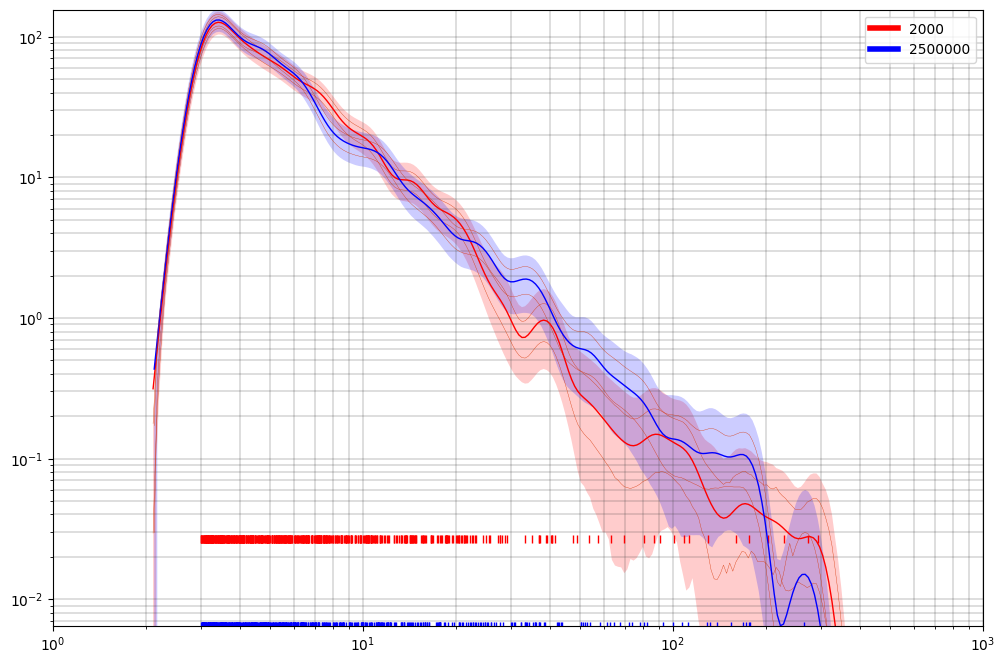

In [366]:
plot_dsfds(
    [diameters_list[i] for i in selections],
    [edf_diam_list[i] for i in selections],
    [edf_dsfd_list[i] for i in selections],
    [edf_erro_dsfd_neg_list[i] for i in selections],
    [edf_erro_dsfd_pos_list[i] for i in selections],
    [edf_erro_dsfd_neg_1s_list[i] for i in selections],
    [edf_erro_dsfd_pos_1s_list[i] for i in selections],
    [labels[i] for i in selections],
    colors=["red", "blue", "orange", "light green"]
)

IndexError: list index out of range

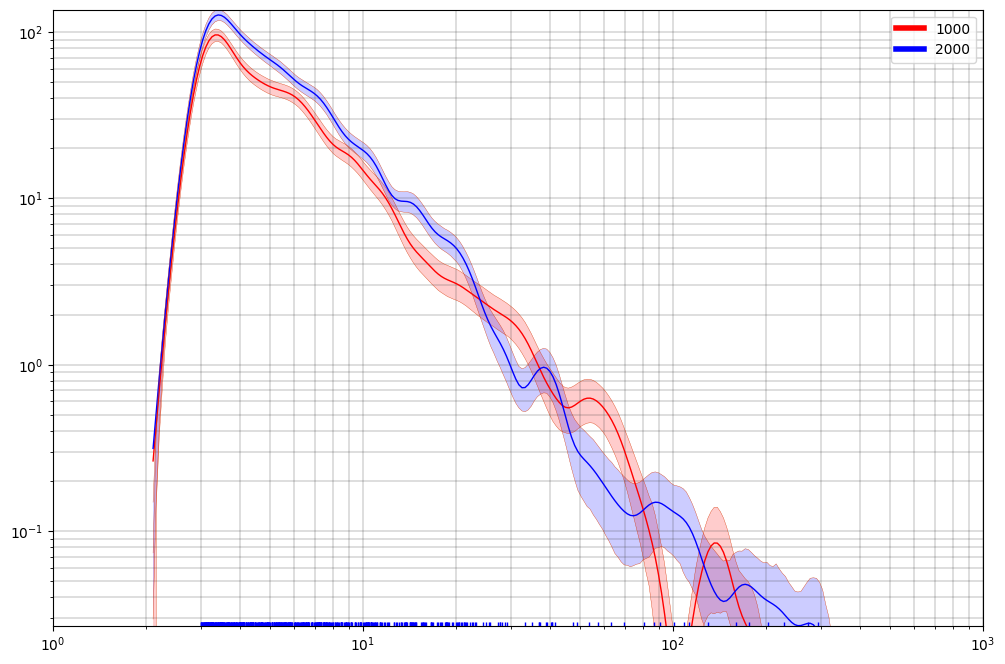

In [213]:
plot_dsfds(
    diameters_list,
    edf_diam_list,
    edf_dsfd_list,
    edf_erro_dsfd_neg_list,
    edf_erro_dsfd_pos_list,
    edf_erro_dsfd_neg_1s_list,
    edf_erro_dsfd_pos_1s_list,
    labels,
    colors=["red", "blue"]
)

In [102]:
s = states.loc[144]
s = np.array(s[s.nstat == 2490000].radius)
s.reshape((len(s), 1))
DIAM_TEMP = s

In [103]:
"""
Created on Fri Mar 11 16:00:00 2016

@author: Stuart J. Robbins

This code will create a size-frequency distribution (SFD) using a kernel density
estimator (KDE), which produces a probability distribution function (PDF). It
models each crater diameter as a Gaussian kernel. It uses a bootstrap sampling
with replacement to calculate confidence intervals. It will both display graphs
of each traditional SFD type (cumulative, relative, differential, incremental)
and output a .CSV table that the user can import into their graphing software of
choice. For more information, see: Robbins et al. (2018) "Revised recommended
methods for analyzing crater size-frequency distributions." Meteoritics &
Planetary Science, 53(4), 891-931. doi: 10.1111/maps.12990.

"""

##TO DO LIST:
# General Software Usability / Options:
#  - Convert all user-set variables to command-line options, and have warnings
#    for when things are incompatible.
#  - Support for more than one set of diameters, especially for display output.
#  - Support for power-law fitting and graphing, both small-end truncated Pareto
#    and large-end.  Output confidences, uncertainty envelopes, and the mini-PDF
#    showing that uncertainty model as introduced by Michael (2016).
#  - Support for fitting Neukum and Hartmann production functions.
#  - Support for user input of file name that has the crater diameters.
#
# KDE:
#  - Multi-thread if desired (it is already very fast for 10s of thousands of
#    craters.
#  - Implement alternative kernals that are controlled with a command-line arg.
#
# Confidence Interval:
#  - Multi-thread.
#  - Implement alternative kernals that are controlled with a command-line arg.
#
# CSV Output:
#  - Allow user to specify file name (control with command-line arg).
#
# Graph Output:
#  - Allow setting of colors.
#  - Proper scaling of axes.
#  - Fix overlapping text due to default Python display of axes tick labels.


import sys
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import scipy.stats as spStats
import scipy.special as spSpecial

np.set_printoptions(threshold=sys.maxsize)  # for debugging purposes


def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


##----------------------------------------------------------------------------##


##----- USER-MODIFIED VARIABLES -----##

d_DIAM_min = 0.03125  # what is the minimum CEIL(diameter) bin - note that this will be smaller in the end due to bin centering
d_apriori_uncertainty = 0.1  # a priori uncertainty on diameter as a multiple of the diameter
d_apriori_Nvariation = 0.0  # a priori variation in number of craters found as a strict fraction of the total (e.g., "0.3" = +/-30%)
d_descretization = 0.01  # fidelity of the descritization in km (or whatever unit the crater diameters are in)
d_sigma_range = 3.0  # range will be min(diameter) - d_sigma_range*min(diameter)'s uncertainty  --to--  d_sigma_range*max(diameter)'s uncertainty + max(diameter)
d_sigma_range_min = 5  # range of KDE starts at min(diameter) - d_sigma_range*min(diameter)'s uncertainty
d_sigma_range_max = 5  # range of KDE ends at d_sigma_range*max(diameter)'s uncertainty + max(diameter)
d_sigma_multiplier_4conf = 1  # bootstrap samples original diameters if difference between adjacent diameters is < THIS VARIABLE * sum of the adjacent diameter uncertainties
i_MonteCarlo_conf_max = 10000  # number of runs to do for confidence bands
i_MonteCarlo_conf_interval = 100  # number of runs to do for confidence bands before checking for convergence
d_MonteCarlo_conf_converge = 1e-4  # tolerance for confidence band convergence
d_confidence = 2  # sigmas of confidence band
d_level_for_completeness = 0.8  # completeness estimate finds the "level" steady-state for the first derivative of the DSDF, when the value is THIS fration of it, that's completeness
f_output_time_diagnostics = 1  # 0 = no, 1 = yes
f_MT = 0  # 0 = no to multi-thread the bootstrap; 1 = yes to do the multi-thread
d_surfacearea = 1  # surface area for normalization

##----- NOTHING BELOW HERE SHOULD BE MODIFIED -----##

# Store the time to output it at the end.
timer_start = time.time()
tt = time.time()

# Output some information to the user.
print(
    "This code factors in:\n\t±%g%% uncertainty on crater diameter\n\t±%g%% uncertainty on number of craters found\n\t%d Monte Carlo runs for the bootstrap-based uncertainty at %d-sigma (±%g%%)\n" % (
    d_apriori_uncertainty * 100, d_apriori_Nvariation * 100, i_MonteCarlo_conf_max, d_confidence,
    spSpecial.erf(d_confidence / math.sqrt(2)) * 100)
    )

##----- SET UP THE DATA AND IMPORTANT VARIABLES AND VECTORS/ARRAYS -----##


# Read the crater data into the array DIAM_TEMP and DIAM_TEMP_SD.  The read-in
# via numpy removes any NaN values (missing rows), so we do not need to check..
# DIAM_TEMP = np.genfromtxt('craters.csv', delimiter=',')
# DIAM_TEMP = np.resize(DIAM_TEMP, (len(DIAM_TEMP), 1))


# Check to see if the minimum diameter (d_DIAM_start) is > the minimum diameter
# crater.  If it is, need to remove those smaller.
if min(DIAM_TEMP) < d_DIAM_min:
    DIAM_TEMP = DIAM_TEMP[DIAM_TEMP > d_DIAM_min]
    print("Removing craters smaller than the d_DIAM_min variable.")

# Sort the diameters (will save time later).
DIAM_TEMP.sort()

# Assign a priori uncertainty.
DIAM_SD_TEMP = d_apriori_uncertainty * DIAM_TEMP  # does not yet support custom uncertainties
if (f_output_time_diagnostics):
    print("Time to read the data: %g seconds" % (time.time() - tt))
    tt = time.time()

# Now that we're done setting up the craters, set other important variables.
# The min and max here will be the min/max diameters to which the KDE
# KDE calculation is carried out.  The total craters saves a tiny amount of time
# so the code doesn't have to keep calculating it.
d_DIAM_min = max(d_DIAM_min, (min(DIAM_TEMP) - d_sigma_range * min(DIAM_SD_TEMP)))
d_DIAM_max = max(DIAM_TEMP) + d_sigma_range * max(DIAM_SD_TEMP)
i_total_craters = len(DIAM_TEMP)

# Determine how many "bins" there will be based on the d_DIAM_min, the largest
# crater, and the descritization variable.
i_number_kde = int(math.floor(math.log10(d_DIAM_max / d_DIAM_min) / d_descretization))

# Declare all the necessary arrays and initialize them.  (Don't worry, we'll change
# the names later.)
edf_diam = np.power(10, (np.log10(d_DIAM_min) + np.arange(0, i_number_kde + 1, 1) * d_descretization))
edf_csfd = [0] * (i_number_kde + 1)
edf_isfd = [0] * (i_number_kde + 1)
edf_dsfd = [0] * (i_number_kde + 1)
edf_rsfd = [0] * (i_number_kde + 1)
edf_erro_csfd_pos_1s = [0] * (i_number_kde + 1)
edf_erro_csfd_pos = [0] * (i_number_kde + 1)
edf_erro_csfd_neg_1s = [0] * (i_number_kde + 1)
edf_erro_csfd_neg = [0] * (i_number_kde + 1)
edf_erro_isfd_pos_1s = [0] * (i_number_kde + 1)
edf_erro_isfd_pos = [0] * (i_number_kde + 1)
edf_erro_isfd_neg_1s = [0] * (i_number_kde + 1)
edf_erro_isfd_neg = [0] * (i_number_kde + 1)
edf_erro_dsfd_pos_1s = [0] * (i_number_kde + 1)
edf_erro_dsfd_pos = [0] * (i_number_kde + 1)
edf_erro_dsfd_neg_1s = [0] * (i_number_kde + 1)
edf_erro_dsfd_neg = [0] * (i_number_kde + 1)
edf_erro_rsfd_pos_1s = [0] * (i_number_kde + 1)
edf_erro_rsfd_pos = [0] * (i_number_kde + 1)
edf_erro_rsfd_neg_1s = [0] * (i_number_kde + 1)
edf_erro_rsfd_neg = [0] * (i_number_kde + 1)

##----- CREATE THE KDE IN DIFFERENTIAL FORMAT -----##


# The actual main KDE algorithm, filling the DIFFERENTIAL size-frequency data.
# This is a kernel density function, meaning that each discrete diameter point
# is treated as a Gaussian distribution.  These are then summed to create the
# kernel.
if (f_output_time_diagnostics):
    print("Time to create all the vectors and set diameter wave: %g seconds" % (tt - timer_start))

##Method 1: Maybe slightly faster than Method 2.  This works by going crater-by-
## crater, determining the diameter range overwhich it will have any influence on
## the kernel, and only doing the math for that diameter range.  Based on tests
## up to ~20,000 craters, it is comparable in speed but maybe 1% faster than the
## next method.
# for i_craterIndex_current in range(0,i_total_craters,1):
#    start = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]-DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
#    stop  = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]+DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
#
#    #Gaussian
#    edf_dsfd[start:stop] += (1./ (i_total_craters*DIAM_SD_TEMP[i_craterIndex_current]*2))*np.exp(-0.5*((edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]*(edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]))

# Method 2: This method goes diameter-by-diameter and sums the kernel contribu-
# tions for every crater for that diameter.  It is likely comparable to Method 1
# only in Python due to numpy optimizations in not doing math when values would
# be very close to zero.  But I am speculating.  The take-home message is that
# if you port this to another language, Method 1 may be significantly faster or
# slower than Method 2, depending.
for i_diameterIndex_current in range(0, int(i_number_kde) + 1, 1):
    # Gaussian
    edf_dsfd[i_diameterIndex_current] = np.sum(
        np.reciprocal(i_total_craters * DIAM_SD_TEMP[:] * 2) * np.exp(
            -0.5 * ((edf_diam[i_diameterIndex_current] - DIAM_TEMP[:]) / DIAM_SD_TEMP[:]) * (
                    (edf_diam[i_diameterIndex_current] - DIAM_TEMP[:]) / DIAM_SD_TEMP[:])
            )
        )

if (f_output_time_diagnostics):
    print("Time to create the empirical density function: %g seconds" % (time.time() - tt))
    tt = time.time()

##----- CREATE THE ALTERNATIVE SFD DISPLAY TYPES -----##


# Divide the differential plot by diameter^-3 to make the R-plot.
edf_rsfd = edf_dsfd[:] * np.power(3, edf_diam[:])

# The definition of the differential is (csfd[i]-csfd[i+1]) / (diam[i+1]-diam[i])
# So to make the incremental, from which we make the cumulative, the incremental
# is (dsfd[i]+dsfd[i+1])/2 * (diam[i+1]-diam[i]).
edf_isfd[:] = edf_dsfd[:]
for i_counter in range(0, len(edf_isfd) - 2):  # there is likely a more Python way to do this
    edf_isfd[i_counter] = (edf_isfd[i_counter] + edf_isfd[i_counter + 1]) / 2 * (
            edf_diam[i_counter + 1] - edf_diam[i_counter])

# "Integrate" the incremental plot to make the cumulative.
edf_csfd[len(edf_csfd) - 1] = edf_isfd[len(edf_isfd) - 1]
for i_counter in range(0, len(edf_isfd) - 1, 1):
    edf_csfd[i_counter] = np.sum(edf_isfd[i_counter:len(edf_csfd)])

# Store NaN to the ultimate value of the DSFD.
edf_dsfd[len(edf_dsfd) - 1] = float('NaN')

# Remove the last point of the incremental.
# edf_isfd[0]                                 = float('NaN')
edf_isfd[len(edf_isfd) - 1] = float('NaN')
# edf_erro_isfd_pos[0]                        = float('NaN')
# edf_erro_isfd_neg[0]                        = float('NaN')
edf_erro_isfd_pos[len(edf_erro_isfd_pos) - 1] = float('NaN')
edf_erro_isfd_neg[len(edf_erro_isfd_neg) - 1] = float('NaN')
# edf_csfd[0]                                 = float('NaN')
# edf_csfd[len(edf_csfd)-1]                   = float('NaN')
# edf_erro_csfd_pos[0]                        = float('NaN')
# edf_erro_csfd_neg[0]                        = float('NaN')
# edf_erro_csfd_pos[len(edf_erro_csfd_pos)-1] = float('NaN')
# edf_erro_csfd_neg[len(edf_erro_csfd_neg)-1] = float('NaN')


##----- CREATE THE CONFIDENCE BANDS -----##

# Bootstrap with resampling to determine confidence intervals.  We have to do
# this after creation of the cumulative because a method to do the bootstrap is
# to sample from the PDF (KDE makes the PDF), and if the PDF is an EDF, it needs
# a cumulative from which to sample.  However, because the cumulative needs to
# be scaled to 1, we need to duplicate it so the scaling is not messed up later.

# Create the 1-CDF for bootstrapping.
edf_cedf = edf_csfd.copy()
dummy_scale = edf_csfd[0]
edf_cedf /= dummy_scale

# Bootstrap with resampling to determine confidence intervals.
bootstrap_data = np.zeros((i_number_kde + 1, i_MonteCarlo_conf_max))
bootstrap_test_converge = np.zeros(
    (i_number_kde + 1, math.ceil(i_MonteCarlo_conf_max / i_MonteCarlo_conf_interval) - 1)
)
if i_MonteCarlo_conf_max > 0:
    if f_MT == 0:
        i_counter1 = 0
        while True:
            #        for i_counter1 in range (0, i_MonteCarlo_conf_max, 1):
            current_bootstrap_iterations = int(
                np.round(i_total_craters * (np.random.uniform(-1, 1) * d_apriori_Nvariation + 1))
            )  # so we can vary number of points per bootstrap
            for i_counter2 in range(0, current_bootstrap_iterations, 1):

                sample_diam = [0] * (current_bootstrap_iterations)  # initialize vector
                sample_sd = [0] * (current_bootstrap_iterations)  # initialize vector

                # Bootstrap sampling from the original diameters.
                # sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                # sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                # sample_diam = DIAM_TEMP[sample_loc]
                # sample_sd   = DIAM_SD_TEMP[sample_loc]

                # Smoothed bootstrap sampling from the original diameters.
                # sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                # sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                # sample_sd   = DIAM_SD_TEMP[sample_loc]
                # sample_diam = DIAM_TEMP[sample_loc]+np.random.normal(0,sample_sd)

                # Smoothed bootstrap sampling from the KDE itself.
                # sample_loc   = [np.random.uniform(0,1) for i in range(current_bootstrap_iterations)] #initialize vector with random numbers
                # for i_counter2 in range (0,int(current_bootstrap_iterations)):
                #    location = find_nearest(edf_cedf,sample_loc[i_counter2])
                #    sample_diam[i_counter2] = edf_diam[location]
                # sample_sd    = np.asarray(sample_diam) * d_apriori_uncertainty

                # Hybrid between smoothed and direct sampling.
                sample_loc = min(
                    round((np.random.uniform(0, 1)) * i_total_craters),
                    i_total_craters - 1
                    )  # create a uniformly distributed random variate in [0,1]
                test_diam = DIAM_TEMP[round(sample_loc)]  # find the random diameter, per method 1
                if sample_loc <= 0.5:  # first part of hybrid, special case for first value
                    sample_diam = DIAM_TEMP[
                        0]  # if we're at or before the first point, use the first real diameter point (avoid spending power where we don't have real craters)
                elif sample_loc >= i_total_craters - 2:  # second part, special case for the largest diameters to follow the EDF
                    sample_diam = edf_diam[int(np.searchsorted(edf_diam, DIAM_TEMP[sample_loc]))]
                elif ((DIAM_TEMP[round(sample_loc)] - DIAM_TEMP[
                    round(sample_loc) - 1]) < d_sigma_multiplier_4conf * d_apriori_uncertainty * (
                          DIAM_TEMP[round(sample_loc)] + DIAM_TEMP[round(sample_loc) - 1])) and ((DIAM_TEMP[round(
                    sample_loc
                ) + 1] - DIAM_TEMP[round(sample_loc)]) < d_sigma_multiplier_4conf * d_apriori_uncertainty * (DIAM_TEMP[
                                                                                                                 round(
                                                                                                                     sample_loc
                                                                                                                 ) + 1] +
                                                                                                             DIAM_TEMP[
                                                                                                                 round(
                                                                                                                     sample_loc
                                                                                                                 )])):
                    sample_diam = test_diam  # third part, if we're in a "dense" region of diameters, use the original diameters
                else:  # fourth part, when we are in a sparse region and want to sample the EDF
                    sample_diam = edf_diam[int(np.searchsorted(edf_diam, DIAM_TEMP[sample_loc]))]
                sample_sd = sample_diam * d_apriori_uncertainty

                # Limit the calculation to a certain range to save time for
                # distributions in the domain (-inf,+inf).
                start = math.floor(np.searchsorted(edf_diam, sample_diam - sample_sd * d_sigma_range))
                stop = min(math.ceil(np.searchsorted(edf_diam, sample_diam + sample_sd * d_sigma_range)), i_number_kde)

                # Gaussian
                for dummy_location in range(
                    start,
                    stop + 1,
                    1
                ):  # could not figure out how to get this to work in Python notation
                    bootstrap_data[dummy_location, i_counter1] += (1 / (i_total_craters * sample_sd * 2)) * math.exp(
                        -0.5 * ((edf_diam[dummy_location] - sample_diam) / sample_sd) * (
                                (edf_diam[dummy_location] - sample_diam) / sample_sd)
                        )

            # Calculate the current confidence intervals to check for converg-
            # ance.  Only doing the positive one to avoid lots of zeros at the
            # large diameters.
            if (((i_counter1 % i_MonteCarlo_conf_interval) == 0) and (i_counter1 > 0)):
                for i_counter3 in range(0, i_number_kde + 1, 1):
                    # For this discretized diameter location, extract the data
                    # from the bootstrap.  Sort it to calculate CIs.
                    dummy = np.zeros(i_counter1)
                    dummy = bootstrap_data[i_counter3][:i_counter1].copy()
                    dummy.sort()

                    # Find the DSFD value in the sorted bootstrap list.
                    V_LevelX = int(np.searchsorted(dummy, edf_dsfd[i_counter3]))

                    # Store to our convergence matrix the difference between the
                    # DSFD value and the +CI from the latest bootstrap for this
                    # discretized diameter location.  Why?  Because our test for
                    # convergence is whether the average of this difference,
                    # across all diameter locations, is less than our threshold.
                    bootstrap_test_converge[i_counter3, int(i_counter1 / i_MonteCarlo_conf_interval - 1)] = abs(
                        edf_dsfd[i_counter3] - dummy[min(
                            int(V_LevelX + (i_counter1 - V_LevelX) * spSpecial.erf(d_confidence / math.sqrt(2))),
                            i_counter1 - 1
                            )]
                        )
                #                    if i_counter3 == 10: print(bootstrap_data[10,:i_counter1],dummy[int(V_LevelX+(i_counter1-V_LevelX)*spSpecial.erf(d_confidence/math.sqrt(2)))])
                #                print(bootstrap_test_converge)
                # Since the point of convergence is something hasn't changed, we
                # can only test after having done this at least twice.
                if i_counter1 / i_MonteCarlo_conf_interval >= 2:
                    # Initialize.
                    bootstrap_test_converge_dsfd = [0] * (i_number_kde + 1)

                    # Calculate the difference between the most recent values in
                    # bootstrap_test_converge and the one before it, and then
                    # normalize by the most recent.  We normalize to get the
                    # fraction difference, rather than an absolute difference.
                    bootstrap_test_converge_dsfd = [abs(
                        bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 1)] -
                        bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 2)]
                        ) / bootstrap_test_converge[counter][int(i_counter1 / i_MonteCarlo_conf_interval - 1)] for
                                                    counter in range(0, i_number_kde)]
                    #                    print(bootstrap_test_converge_dsfd)

                    # Now do the testing.  Need to avoid NaNs for numpy, so have
                    # to specifically index within the averaging.
                    print(
                        np.average(bootstrap_test_converge_dsfd[0:int(i_counter1 / i_MonteCarlo_conf_interval)])
                    )  # , bootstrap_data[5,i_counter1], bootstrap_data[5,i_counter1-1], bootstrap_data[5,i_counter1]-bootstrap_data[5,i_counter1-1])
                    if (np.average(
                        bootstrap_test_converge_dsfd[0:int(i_counter1 / i_MonteCarlo_conf_interval)]
                    ) <= d_MonteCarlo_conf_converge):
                        i_MonteCarlo_conf_max = i_counter1
                        f_MonteCarlo_converge = 1
                        print(
                            "Bootstrap converged to %e after %g iterations.\n" % (
                            d_MonteCarlo_conf_converge, i_MonteCarlo_conf_max)
                            )

            # Increment the counter through the Monte Carlo iterations and test
            # for being done.
            i_counter1 += 1
            if i_counter1 >= i_MonteCarlo_conf_max:
                break



    else:
        # ---multi-threading not yet coded!!---#
        BootstrapMTPrepare(
            DIAM_TEMP,
            DIAM_SD_TEMP,
            edf_diam,
            bootstrap_data,
            i_number_kde,
            i_MonteCarlo_conf_max,
            i_total_craters
        )

    if (f_output_time_diagnostics):
        print("Time to bootstrap to create the confidence interval: %g seconds" % (time.time() - tt))
        tt = time.time()

    for i_counter1 in range(0, i_number_kde + 1):
        dummy = np.zeros(i_MonteCarlo_conf_max)
        dummy[:] = bootstrap_data[i_counter1][:len(dummy)]  # in case we truncated due to convergence!
        dummy.sort()
        level = find_nearest(dummy, edf_dsfd[i_counter1])
        # edf_erro_dsfd_neg[i_counter1] = np.abs( edf_dsfd[i_counter1]-dummy[level*(1-spSpecial.erf(d_confidence/np.sqrt(2.)))] )
        # edf_erro_dsfd_pos[i_counter1] = np.abs( edf_dsfd[i_counter1]+dummy[level+(i_MonteCarlo_conf_max-level)*spSpecial.erf(d_confidence/np.sqrt(2.))] )
        edf_erro_dsfd_neg[i_counter1] = dummy[int(level * (1 - spSpecial.erf(d_confidence / np.sqrt(2.))))]
        edf_erro_dsfd_neg_1s[i_counter1] = dummy[int(level * (1 - spSpecial.erf(1. / np.sqrt(2.))))]
        edf_erro_dsfd_pos[i_counter1] = dummy[
            int(level + (i_MonteCarlo_conf_max - level) * spSpecial.erf(d_confidence / np.sqrt(2.)))]
        edf_erro_dsfd_pos_1s[i_counter1] = dummy[
            int(level + (i_MonteCarlo_conf_max - level) * spSpecial.erf(1. / np.sqrt(2.)))]
    if (f_output_time_diagnostics):
        print("Time to create the confidence interval from the bootstrapped data: %g seconds" % (time.time() - tt))
        tt = time.time()
# No idea why, but for some reason these get reshaped to be 100x their should-be size.
edf_diam = edf_diam.reshape(i_number_kde + 1)

# The kernel density plot needs to be scaled to get it into real numbers.  Figure
# out that scaling and apply it to both the kernel and the cumulative.
d_scaling = len(DIAM_TEMP) / edf_csfd[0] / d_surfacearea
edf_dsfd = np.array(edf_dsfd) * d_scaling
edf_erro_dsfd_neg = np.array(edf_erro_dsfd_neg) * d_scaling
edf_erro_dsfd_pos = np.array(edf_erro_dsfd_pos) * d_scaling
edf_erro_dsfd_neg_1s = np.array(edf_erro_dsfd_neg_1s) * d_scaling
edf_erro_dsfd_pos_1s = np.array(edf_erro_dsfd_pos_1s) * d_scaling
edf_rsfd = np.array(edf_rsfd) * d_scaling
edf_erro_rsfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_rsfd)
edf_erro_rsfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_rsfd)
edf_erro_rsfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_rsfd)
edf_erro_rsfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_rsfd)
edf_isfd = np.array(edf_isfd) * d_scaling
edf_erro_isfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_isfd)
edf_erro_isfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_isfd)
edf_erro_isfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_isfd)
edf_erro_isfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_isfd)
edf_csfd = np.array(edf_csfd) * d_scaling
edf_erro_csfd_neg = np.multiply(np.divide(edf_erro_dsfd_neg, edf_dsfd), edf_csfd)
edf_erro_csfd_pos = np.multiply(np.divide(edf_erro_dsfd_pos, edf_dsfd), edf_csfd)
edf_erro_csfd_neg_1s = np.multiply(np.divide(edf_erro_dsfd_neg_1s, edf_dsfd), edf_csfd)
edf_erro_csfd_pos_1s = np.multiply(np.divide(edf_erro_dsfd_pos_1s, edf_dsfd), edf_csfd)
if (f_output_time_diagnostics):
    print("Time to create all the other plots and scale: %g seconds" % (time.time() - tt))
    tt = time.time()

# Output the time.
print("Creating the SFD took %g seconds." % (time.time() - timer_start))

This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 0.00056386 seconds
Time to create all the vectors and set diameter wave: 0.000617266 seconds
Time to create the empirical density function: 0.00476456 seconds
0.0
Bootstrap converged to 1.000000e-04 after 200 iterations.

Time to bootstrap to create the confidence interval: 3.57416 seconds
Time to create the confidence interval from the bootstrapped data: 0.00323963 seconds
Time to create all the other plots and scale: 0.000631094 seconds
Creating the SFD took 3.58348 seconds.


In [126]:
diameters_list.append(DIAM_TEMP)
edf_diam_list.append(edf_diam)
edf_dsfd_list.append(edf_dsfd)
edf_erro_dsfd_neg_list.append(edf_erro_dsfd_neg)
edf_erro_dsfd_pos_list.append(edf_erro_dsfd_pos)
edf_erro_dsfd_neg_1s_list.append(edf_erro_dsfd_neg_1s)
edf_erro_dsfd_pos_1s_list.append(edf_erro_dsfd_pos_1s)

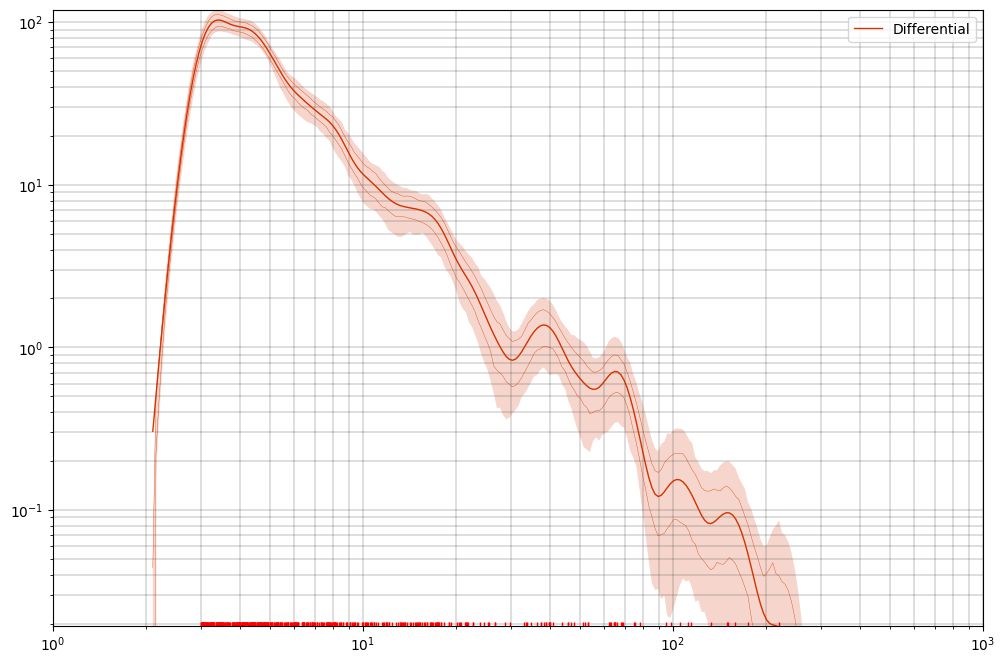

In [127]:
diameters_list.append(DIAM_TEMP)
edf_diam_list.append(edf_diam)
edf_dsfd_list.append(edf_dsfd)
edf_erro_dsfd_neg_list.append(edf_erro_dsfd_neg)
edf_erro_dsfd_pos_list.append(edf_erro_dsfd_pos)
edf_erro_dsfd_neg_1s_list.append(edf_erro_dsfd_neg_1s)
edf_erro_dsfd_pos_1s_list.append(edf_erro_dsfd_pos_1s)

plot_dsfds(
    diameters_list,
    edf_diam_list,
    edf_dsfd_list,
    edf_erro_dsfd_neg_list,
    edf_erro_dsfd_pos_list,
    edf_erro_dsfd_neg_1s_list,
    edf_erro_dsfd_pos_1s_list,
)

nstat = 100.0
This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 4.3869e-05 seconds
Time to create all the vectors and set diameter wave: 5.17368e-05 seconds
Time to create the empirical density function: 0.00210285 seconds
Time to bootstrap to create the confidence interval: 28.2137 seconds
Time to create the confidence interval from the bootstrapped data: 0.0549991 seconds
Time to create all the other plots and scale: 8.9407e-05 seconds
Creating the SFD took 28.2711 seconds.


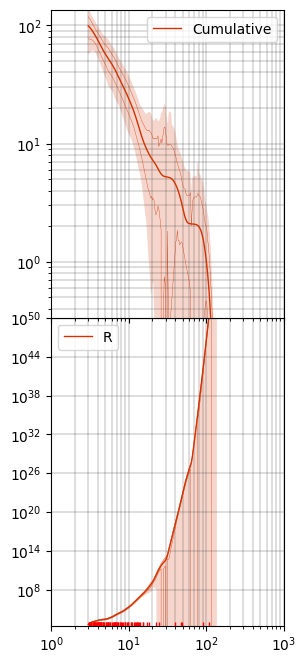

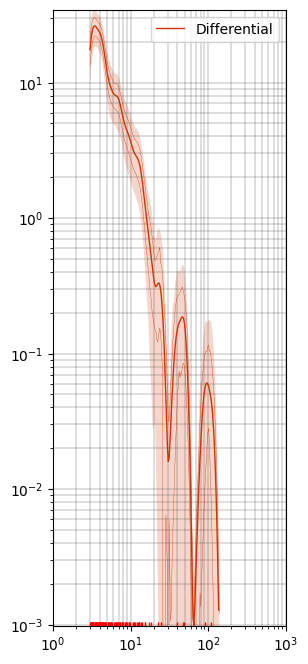

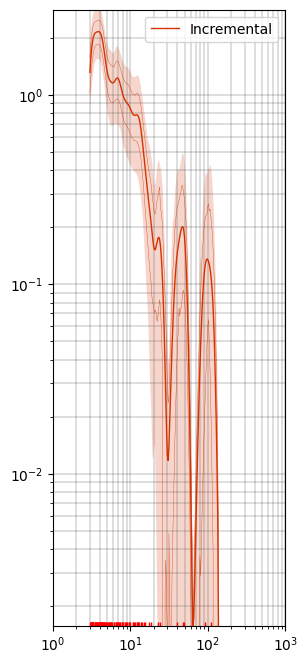

nstat = 1000.0
This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 0.000122786 seconds
Time to create all the vectors and set diameter wave: 0.000131369 seconds
Time to create the empirical density function: 0.00304651 seconds
Bootstrap converged to 1.000000e-04 after 200 iterations.

Time to bootstrap to create the confidence interval: 2.44331 seconds
Time to create the confidence interval from the bootstrapped data: 0.00294161 seconds
Time to create all the other plots and scale: 8.82149e-05 seconds
Creating the SFD took 2.44954 seconds.


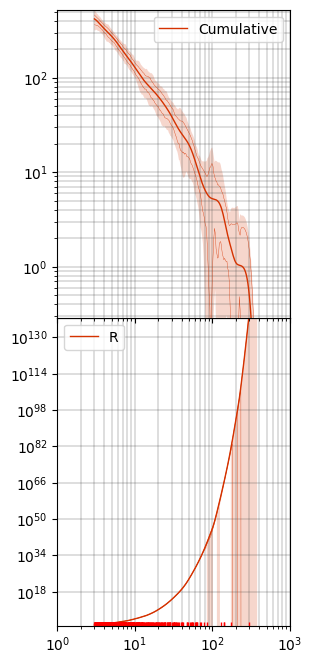

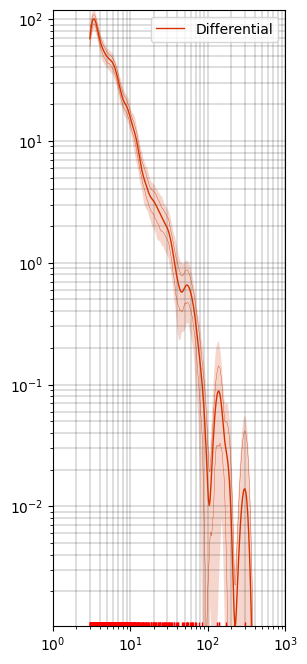

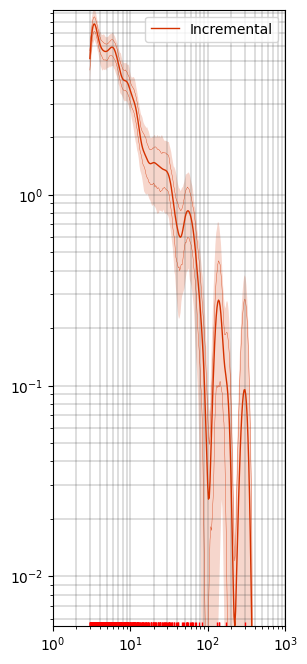

nstat = 10000.0
This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 9.32217e-05 seconds
Time to create all the vectors and set diameter wave: 0.000101328 seconds
Time to create the empirical density function: 0.0037601 seconds
Time to bootstrap to create the confidence interval: 179.169 seconds
Time to create the confidence interval from the bootstrapped data: 0.0810456 seconds
Time to create all the other plots and scale: 0.000119209 seconds
Creating the SFD took 179.254 seconds.


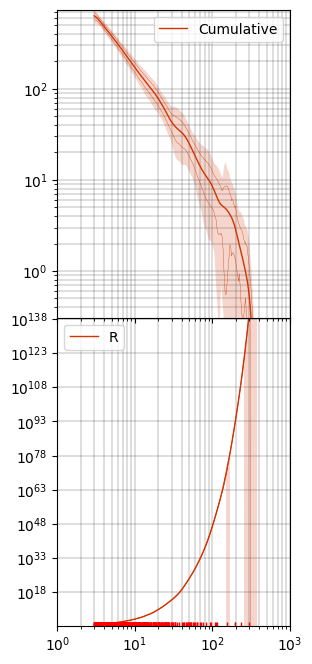

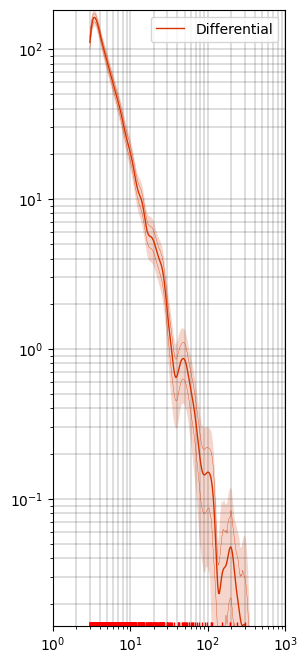

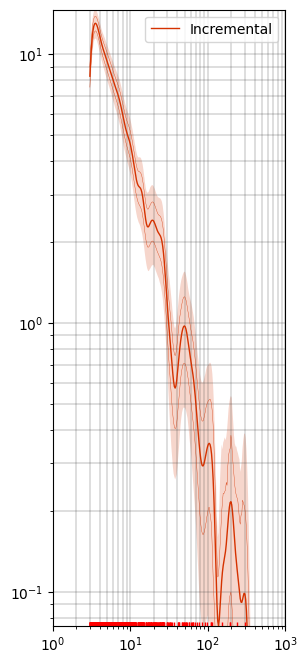

nstat = 100000.0
This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 6.19888e-05 seconds
Time to create all the vectors and set diameter wave: 6.79493e-05 seconds
Time to create the empirical density function: 0.00318122 seconds
Time to bootstrap to create the confidence interval: 159.481 seconds
Time to create the confidence interval from the bootstrapped data: 0.0810342 seconds
Time to create all the other plots and scale: 0.000103951 seconds
Creating the SFD took 159.565 seconds.


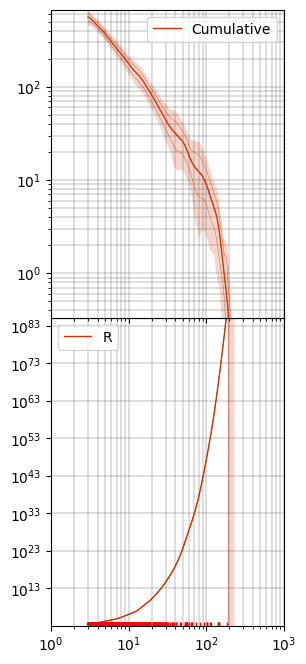

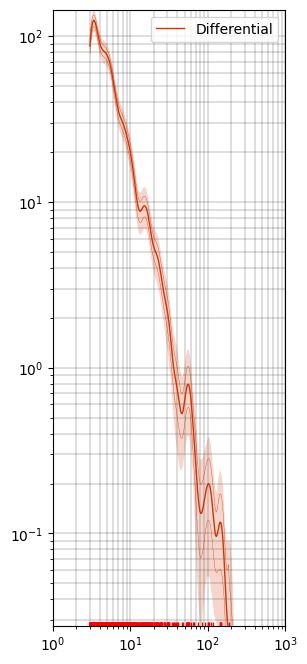

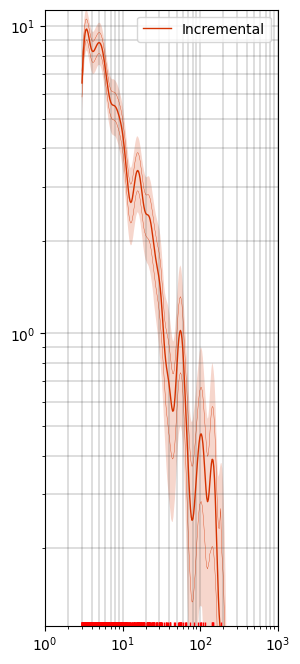

nstat = 2500000.0
This code factors in:
	±10% uncertainty on crater diameter
	±0% uncertainty on number of craters found
	10000 Monte Carlo runs for the bootstrap-based uncertainty at 2-sigma (±95.45%)

Time to read the data: 0.000127554 seconds
Time to create all the vectors and set diameter wave: 0.000136375 seconds
Time to create the empirical density function: 0.00355434 seconds
Bootstrap converged to 1.000000e-04 after 200 iterations.

Time to bootstrap to create the confidence interval: 3.22194 seconds
Time to create the confidence interval from the bootstrapped data: 0.00293922 seconds
Time to create all the other plots and scale: 0.000102758 seconds
Creating the SFD took 3.2287 seconds.


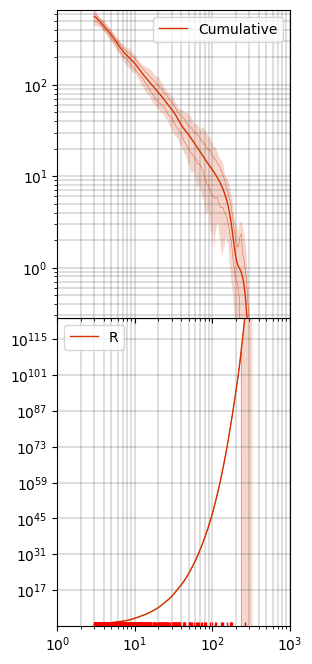

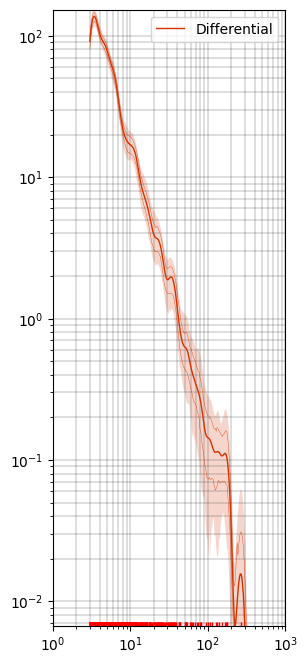

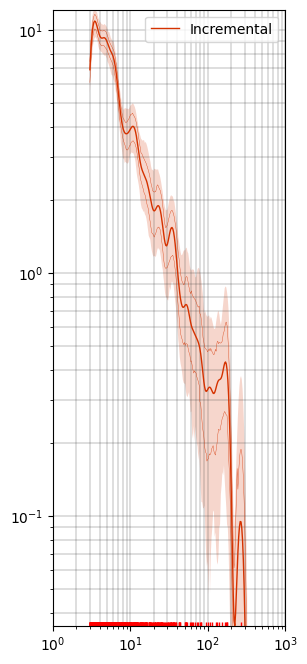

In [45]:
for simulation_id in simulation_ids:
    stats_df = spark.read.parquet(f"{BASE_PATH}/{simulation_id}/statistics_*.parquet")
    craters_df = spark.read.parquet( f"{BASE_PATH}/{simulation_id}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{BASE_PATH}/{simulation_id}/crater_removals_*.parquet")
    
    states = get_states(
        stats_df=stats_df,
        craters_df=craters_df,
        removals_df=removals_df,
        nstats=nstats,
        study_region_size=study_region_size,
        study_region_padding=study_region_padding,
        spark=spark,
        result_columns=["crater_id", "radius", "nstat"],
    )
    states["simulation_id"] = simulation_id
    states = states.set_index("simulation_id").sort_index()
    states.to_parquet(f"data/ad_test_states_{simulation_id}_{N_NSTATS}.parquet")


    for nstat in nstats:
        print(f"nstat = {nstat}")
        s = states.loc[144]
        s = np.array(s[s.nstat == nstat].radius)
        s.reshape((len(s), 1))
        DIAM_TEMP = s
        
        """
        Created on Fri Mar 11 16:00:00 2016
        
        @author: Stuart J. Robbins
        
        This code will create a size-frequency distribution (SFD) using a kernel density
        estimator (KDE), which produces a probability distribution function (PDF). It
        models each crater diameter as a Gaussian kernel. It uses a bootstrap sampling
        with replacement to calculate confidence intervals. It will both display graphs
        of each traditional SFD type (cumulative, relative, differential, incremental)
        and output a .CSV table that the user can import into their graphing software of
        choice. For more information, see: Robbins et al. (2018) "Revised recommended
        methods for analyzing crater size-frequency distributions." Meteoritics &
        Planetary Science, 53(4), 891-931. doi: 10.1111/maps.12990.
        
        """
        
        ##TO DO LIST:
        #General Software Usability / Options:
        #  - Convert all user-set variables to command-line options, and have warnings
        #    for when things are incompatible.
        #  - Support for more than one set of diameters, especially for display output.
        #  - Support for power-law fitting and graphing, both small-end truncated Pareto
        #    and large-end.  Output confidences, uncertainty envelopes, and the mini-PDF
        #    showing that uncertainty model as introduced by Michael (2016).
        #  - Support for fitting Neukum and Hartmann production functions.
        #  - Support for user input of file name that has the crater diameters.
        #
        #KDE:
        #  - Multi-thread if desired (it is already very fast for 10s of thousands of
        #    craters.
        #  - Implement alternative kernals that are controlled with a command-line arg.
        #
        #Confidence Interval:
        #  - Multi-thread.
        #  - Implement alternative kernals that are controlled with a command-line arg.
        #
        #CSV Output:
        #  - Allow user to specify file name (control with command-line arg).
        #
        #Graph Output:
        #  - Allow setting of colors.
        #  - Proper scaling of axes.
        #  - Fix overlapping text due to default Python display of axes tick labels.
        
        
        import sys
        import numpy as np
        import math
        import time
        import matplotlib.pyplot as plt
        import scipy.stats as spStats
        import scipy.special as spSpecial
        
        np.set_printoptions(threshold=sys.maxsize) #for debugging purposes
        
        
        
        
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx
        
        
        ##----------------------------------------------------------------------------##
        
        
        
        ##----- USER-MODIFIED VARIABLES -----##
        
        # d_DIAM_min                  = 0.03125   #what is the minimum CEIL(diameter) bin - note that this will be smaller in the end due to bin centering
        d_DIAM_min                  = 3   #what is the minimum CEIL(diameter) bin - note that this will be smaller in the end due to bin centering
        d_apriori_uncertainty       = 0.1       #a priori uncertainty on diameter as a multiple of the diameter
        d_apriori_Nvariation        = 0.0		#a priori variation in number of craters found as a strict fraction of the total (e.g., "0.3" = +/-30%)
        d_descretization            = 0.01      #fidelity of the descritization in km (or whatever unit the crater diameters are in)
        d_sigma_range               = 3.0       #range will be min(diameter) - d_sigma_range*min(diameter)'s uncertainty  --to--  d_sigma_range*max(diameter)'s uncertainty + max(diameter)
        d_sigma_range_min           = 5         #range of KDE starts at min(diameter) - d_sigma_range*min(diameter)'s uncertainty
        d_sigma_range_max           = 5         #range of KDE ends at d_sigma_range*max(diameter)'s uncertainty + max(diameter)
        d_sigma_multiplier_4conf    = 1         #bootstrap samples original diameters if difference between adjacent diameters is < THIS VARIABLE * sum of the adjacent diameter uncertainties
        i_MonteCarlo_conf_max       = 10000      #number of runs to do for confidence bands
        i_MonteCarlo_conf_interval  = 100       #number of runs to do for confidence bands before checking for convergence
        d_MonteCarlo_conf_converge  = 1e-4      #tolerance for confidence band convergence
        d_confidence                = 2         #sigmas of confidence band
        d_level_for_completeness    = 0.8       #completeness estimate finds the "level" steady-state for the first derivative of the DSDF, when the value is THIS fration of it, that's completeness
        f_output_time_diagnostics   = 1         #0 = no, 1 = yes
        f_MT                        = 0         #0 = no to multi-thread the bootstrap; 1 = yes to do the multi-thread
        d_surfacearea               = 1         #surface area for normalization
        
        
        
        ##----- NOTHING BELOW HERE SHOULD BE MODIFIED -----##
        
        #Store the time to output it at the end.
        timer_start = time.time()
        tt = time.time()
        
        #Output some information to the user.
        print("This code factors in:\n\t±%g%% uncertainty on crater diameter\n\t±%g%% uncertainty on number of craters found\n\t%d Monte Carlo runs for the bootstrap-based uncertainty at %d-sigma (±%g%%)\n" % (d_apriori_uncertainty*100, d_apriori_Nvariation*100,i_MonteCarlo_conf_max,d_confidence,spSpecial.erf(d_confidence/math.sqrt(2))*100))
        
        
        
        ##----- SET UP THE DATA AND IMPORTANT VARIABLES AND VECTORS/ARRAYS -----##
        
        
        #Read the crater data into the array DIAM_TEMP and DIAM_TEMP_SD.  The read-in
        # via numpy removes any NaN values (missing rows), so we do not need to check..
        # DIAM_TEMP = np.genfromtxt('data/craters.csv',delimiter=',')
        # DIAM_TEMP = np.resize(DIAM_TEMP,(len(DIAM_TEMP),1))
        
        #Check to see if the minimum diameter (d_DIAM_start) is > the minimum diameter
        # crater.  If it is, need to remove those smaller.
        if min(DIAM_TEMP) < d_DIAM_min:
            DIAM_TEMP = DIAM_TEMP[DIAM_TEMP > d_DIAM_min]
            print("Removing craters smaller than the d_DIAM_min variable.")
        
        #Sort the diameters (will save time later).
        DIAM_TEMP.sort()
        
        #Assign a priori uncertainty.
        DIAM_SD_TEMP = d_apriori_uncertainty*DIAM_TEMP      #does not yet support custom uncertainties
        if(f_output_time_diagnostics):
            print("Time to read the data: %g seconds" % (time.time()-tt))
            tt=time.time()
        
        
        #Now that we're done setting up the craters, set other important variables.
        # The min and max here will be the min/max diameters to which the KDE
        # KDE calculation is carried out.  The total craters saves a tiny amount of time
        # so the code doesn't have to keep calculating it.
        d_DIAM_min      = max(d_DIAM_min,(min(DIAM_TEMP)-d_sigma_range*min(DIAM_SD_TEMP)))
        d_DIAM_max      = max(DIAM_TEMP)+d_sigma_range*max(DIAM_SD_TEMP)
        i_total_craters = len(DIAM_TEMP)
        
        
        #Determine how many "bins" there will be based on the d_DIAM_min, the largest
        # crater, and the descritization variable.
        i_number_kde    = int(math.floor(math.log10(d_DIAM_max/d_DIAM_min)/d_descretization))
        
        #Declare all the necessary arrays and initialize them.  (Don't worry, we'll change
        # the names later.)
        edf_diam                = np.power(10,(np.log10(d_DIAM_min)+np.arange(0,i_number_kde+1,1)*d_descretization))
        edf_csfd                = [0]*(i_number_kde+1)
        edf_isfd                = [0]*(i_number_kde+1)
        edf_dsfd                = [0]*(i_number_kde+1)
        edf_rsfd                = [0]*(i_number_kde+1)
        edf_erro_csfd_pos_1s    = [0]*(i_number_kde+1)
        edf_erro_csfd_pos       = [0]*(i_number_kde+1)
        edf_erro_csfd_neg_1s    = [0]*(i_number_kde+1)
        edf_erro_csfd_neg       = [0]*(i_number_kde+1)
        edf_erro_isfd_pos_1s    = [0]*(i_number_kde+1)
        edf_erro_isfd_pos       = [0]*(i_number_kde+1)
        edf_erro_isfd_neg_1s    = [0]*(i_number_kde+1)
        edf_erro_isfd_neg       = [0]*(i_number_kde+1)
        edf_erro_dsfd_pos_1s    = [0]*(i_number_kde+1)
        edf_erro_dsfd_pos       = [0]*(i_number_kde+1)
        edf_erro_dsfd_neg_1s    = [0]*(i_number_kde+1)
        edf_erro_dsfd_neg       = [0]*(i_number_kde+1)
        edf_erro_rsfd_pos_1s    = [0]*(i_number_kde+1)
        edf_erro_rsfd_pos       = [0]*(i_number_kde+1)
        edf_erro_rsfd_neg_1s    = [0]*(i_number_kde+1)
        edf_erro_rsfd_neg       = [0]*(i_number_kde+1)
        
        
        
        ##----- CREATE THE KDE IN DIFFERENTIAL FORMAT -----##
        
        
        #The actual main KDE algorithm, filling the DIFFERENTIAL size-frequency data.
        # This is a kernel density function, meaning that each discrete diameter point
        # is treated as a Gaussian distribution.  These are then summed to create the
        # kernel.
        if(f_output_time_diagnostics):
            print("Time to create all the vectors and set diameter wave: %g seconds" % (tt-timer_start))
        
        ##Method 1: Maybe slightly faster than Method 2.  This works by going crater-by-
        ## crater, determining the diameter range overwhich it will have any influence on
        ## the kernel, and only doing the math for that diameter range.  Based on tests
        ## up to ~20,000 craters, it is comparable in speed but maybe 1% faster than the
        ## next method.
        #for i_craterIndex_current in range(0,i_total_craters,1):
        #    start = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]-DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
        #    stop  = int(np.searchsorted(edf_diam, DIAM_TEMP[i_craterIndex_current]+DIAM_SD_TEMP[i_craterIndex_current]*d_sigma_range))
        #
        #    #Gaussian
        #    edf_dsfd[start:stop] += (1./ (i_total_craters*DIAM_SD_TEMP[i_craterIndex_current]*2))*np.exp(-0.5*((edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]*(edf_diam[start:stop]-DIAM_TEMP[i_craterIndex_current])/DIAM_SD_TEMP[i_craterIndex_current]))
        
        #Method 2: This method goes diameter-by-diameter and sums the kernel contribu-
        # tions for every crater for that diameter.  It is likely comparable to Method 1
        # only in Python due to numpy optimizations in not doing math when values would
        # be very close to zero.  But I am speculating.  The take-home message is that
        # if you port this to another language, Method 1 may be significantly faster or
        # slower than Method 2, depending.
        for i_diameterIndex_current in range(0,int(i_number_kde)+1,1):
            #Gaussian
            edf_dsfd[i_diameterIndex_current] = np.sum( np.reciprocal(i_total_craters*DIAM_SD_TEMP[:]*2)*np.exp(-0.5*((edf_diam[i_diameterIndex_current]-DIAM_TEMP[:])/DIAM_SD_TEMP[:])*((edf_diam[i_diameterIndex_current]-DIAM_TEMP[:])/DIAM_SD_TEMP[:])) )
        
        if(f_output_time_diagnostics):
            print("Time to create the empirical density function: %g seconds" % (time.time()-tt))
            tt=time.time()
        
        
        
        ##----- CREATE THE ALTERNATIVE SFD DISPLAY TYPES -----##
        
        
        #Divide the differential plot by diameter^-3 to make the R-plot.
        edf_rsfd = edf_dsfd[:] * np.power(3,edf_diam[:])
        
        #The definition of the differential is (csfd[i]-csfd[i+1]) / (diam[i+1]-diam[i])
        # So to make the incremental, from which we make the cumulative, the incremental
        # is (dsfd[i]+dsfd[i+1])/2 * (diam[i+1]-diam[i]).
        edf_isfd[:] = edf_dsfd[:]
        for i_counter in range(0, len(edf_isfd)-2): #there is likely a more Python way to do this
            edf_isfd[i_counter] = (edf_isfd[i_counter]+edf_isfd[i_counter+1])/2 * (edf_diam[i_counter+1]-edf_diam[i_counter])
        
        #"Integrate" the incremental plot to make the cumulative.
        edf_csfd[len(edf_csfd)-1] = edf_isfd[len(edf_isfd)-1]
        for i_counter in range(0, len(edf_isfd)-1, 1):
            edf_csfd[i_counter] = np.sum(edf_isfd[i_counter:len(edf_csfd)])
        
        #Store NaN to the ultimate value of the DSFD.
        edf_dsfd[len(edf_dsfd)-1] = float('NaN')
        
        #Remove the last point of the incremental.
        #edf_isfd[0]                                 = float('NaN')
        edf_isfd[len(edf_isfd)-1]                   = float('NaN')
        #edf_erro_isfd_pos[0]                        = float('NaN')
        #edf_erro_isfd_neg[0]                        = float('NaN')
        edf_erro_isfd_pos[len(edf_erro_isfd_pos)-1] = float('NaN')
        edf_erro_isfd_neg[len(edf_erro_isfd_neg)-1] = float('NaN')
        #edf_csfd[0]                                 = float('NaN')
        #edf_csfd[len(edf_csfd)-1]                   = float('NaN')
        #edf_erro_csfd_pos[0]                        = float('NaN')
        #edf_erro_csfd_neg[0]                        = float('NaN')
        #edf_erro_csfd_pos[len(edf_erro_csfd_pos)-1] = float('NaN')
        #edf_erro_csfd_neg[len(edf_erro_csfd_neg)-1] = float('NaN')
        
        
        
        ##----- CREATE THE CONFIDENCE BANDS -----##
        
        #Bootstrap with resampling to determine confidence intervals.  We have to do
        # this after creation of the cumulative because a method to do the bootstrap is
        # to sample from the PDF (KDE makes the PDF), and if the PDF is an EDF, it needs
        # a cumulative from which to sample.  However, because the cumulative needs to
        # be scaled to 1, we need to duplicate it so the scaling is not messed up later.
        
        #Create the 1-CDF for bootstrapping.
        edf_cedf = edf_csfd.copy()
        dummy_scale = edf_csfd[0]
        edf_cedf   /= dummy_scale
        
        
        #Bootstrap with resampling to determine confidence intervals.
        bootstrap_data = np.zeros((i_number_kde+1,i_MonteCarlo_conf_max))
        bootstrap_test_converge = np.zeros((i_number_kde+1,math.ceil(i_MonteCarlo_conf_max/i_MonteCarlo_conf_interval)-1))
        if i_MonteCarlo_conf_max > 0:
            if f_MT == 0:
                i_counter1 = 0
                while True:
        #        for i_counter1 in range (0, i_MonteCarlo_conf_max, 1):
                    current_bootstrap_iterations = int(np.round(i_total_craters*(np.random.uniform(-1,1)*d_apriori_Nvariation+1)))  #so we can vary number of points per bootstrap
                    for i_counter2 in range (0, current_bootstrap_iterations, 1):
        
                        sample_diam = [0]*(current_bootstrap_iterations) #initialize vector
                        sample_sd   = [0]*(current_bootstrap_iterations) #initialize vector
                        
                        #Bootstrap sampling from the original diameters.
                        #sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                        #sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                        #sample_diam = DIAM_TEMP[sample_loc]
                        #sample_sd   = DIAM_SD_TEMP[sample_loc]
                        
                        #Smoothed bootstrap sampling from the original diameters.
                        #sample_loc  = [int(np.random.uniform(0,i_total_craters-1)) for i in range(i_total_craters-1)] #initialize vector with random numbers
                        #sample_loc  = np.array(sample_loc).reshape(i_total_craters-1) #convert to numpy and lop off one dimension
                        #sample_sd   = DIAM_SD_TEMP[sample_loc]
                        #sample_diam = DIAM_TEMP[sample_loc]+np.random.normal(0,sample_sd)
                        
                        #Smoothed bootstrap sampling from the KDE itself.
                        #sample_loc   = [np.random.uniform(0,1) for i in range(current_bootstrap_iterations)] #initialize vector with random numbers
                        #for i_counter2 in range (0,int(current_bootstrap_iterations)):
                        #    location = find_nearest(edf_cedf,sample_loc[i_counter2])
                        #    sample_diam[i_counter2] = edf_diam[location]
                        #sample_sd    = np.asarray(sample_diam) * d_apriori_uncertainty
        
                        #Hybrid between smoothed and direct sampling.
                        sample_loc  = min(round((np.random.uniform(0,1))*i_total_craters),i_total_craters-1) #create a uniformly distributed random variate in [0,1]
                        test_diam   = DIAM_TEMP[round(sample_loc)]              #find the random diameter, per method 1
                        if sample_loc <= 0.5:                                   #first part of hybrid, special case for first value
                            sample_diam = DIAM_TEMP[0]                          #if we're at or before the first point, use the first real diameter point (avoid spending power where we don't have real craters)
                        elif sample_loc >= i_total_craters-2:                   #second part, special case for the largest diameters to follow the EDF
                            sample_diam = edf_diam[int(np.searchsorted(edf_diam,DIAM_TEMP[sample_loc]))]
                        elif ((DIAM_TEMP[round(sample_loc)]-DIAM_TEMP[round(sample_loc)-1]) < d_sigma_multiplier_4conf*d_apriori_uncertainty*(DIAM_TEMP[round(sample_loc)]+DIAM_TEMP[round(sample_loc)-1])) and ((DIAM_TEMP[round(sample_loc)+1]-DIAM_TEMP[round(sample_loc)]) < d_sigma_multiplier_4conf*d_apriori_uncertainty*(DIAM_TEMP[round(sample_loc)+1]+DIAM_TEMP[round(sample_loc)])):
                            sample_diam = test_diam                             #third part, if we're in a "dense" region of diameters, use the original diameters
                        else:                                                   #fourth part, when we are in a sparse region and want to sample the EDF
                            sample_diam = edf_diam[int(np.searchsorted(edf_diam,DIAM_TEMP[sample_loc]))]
                        sample_sd   = sample_diam * d_apriori_uncertainty
                        
                        #Limit the calculation to a certain range to save time for
                        # distributions in the domain (-inf,+inf).
                        start =     math.floor(np.searchsorted(edf_diam, sample_diam-sample_sd*d_sigma_range))
                        stop  = min(math.ceil (np.searchsorted(edf_diam, sample_diam+sample_sd*d_sigma_range)),i_number_kde)
                        
                        #Gaussian
                        for dummy_location in range(start, stop+1, 1): #could not figure out how to get this to work in Python notation
                            bootstrap_data[dummy_location,i_counter1] += (1/(i_total_craters*sample_sd*2))*math.exp(-0.5*((edf_diam[dummy_location]-sample_diam)/sample_sd)*((edf_diam[dummy_location]-sample_diam)/sample_sd))
                    
        
                    #Calculate the current confidence intervals to check for converg-
                    # ance.  Only doing the positive one to avoid lots of zeros at the
                    # large diameters.
                    if(((i_counter1 % i_MonteCarlo_conf_interval) == 0) and (i_counter1 > 0)):
                        for i_counter3 in range(0, i_number_kde+1, 1):
                            #For this discretized diameter location, extract the data
                            # from the bootstrap.  Sort it to calculate CIs.
                            dummy = np.zeros(i_counter1)
                            dummy = bootstrap_data[i_counter3][:i_counter1].copy()
                            dummy.sort()
        
                            #Find the DSFD value in the sorted bootstrap list.
                            V_LevelX = int(np.searchsorted(dummy,edf_dsfd[i_counter3]))
                            
                            #Store to our convergence matrix the difference between the
                            # DSFD value and the +CI from the latest bootstrap for this
                            # discretized diameter location.  Why?  Because our test for
                            # convergence is whether the average of this difference,
                            # across all diameter locations, is less than our threshold.
                            bootstrap_test_converge[i_counter3, int(i_counter1/i_MonteCarlo_conf_interval-1)] = abs( edf_dsfd[i_counter3]-dummy[min(int(V_LevelX+(i_counter1-V_LevelX)*spSpecial.erf(d_confidence/math.sqrt(2))),i_counter1-1)] )
        #                    if i_counter3 == 10: print(bootstrap_data[10,:i_counter1],dummy[int(V_LevelX+(i_counter1-V_LevelX)*spSpecial.erf(d_confidence/math.sqrt(2)))])
        #                print(bootstrap_test_converge)
                        #Since the point of convergence is something hasn't changed, we
                        # can only test after having done this at least twice.
                        if i_counter1/i_MonteCarlo_conf_interval >= 2:
                            #Initialize.
                            bootstrap_test_converge_dsfd = [0]*(i_number_kde+1)
                            
                            #Calculate the difference between the most recent values in
                            # bootstrap_test_converge and the one before it, and then
                            # normalize by the most recent.  We normalize to get the
                            # fraction difference, rather than an absolute difference.
                            bootstrap_test_converge_dsfd = [abs( bootstrap_test_converge[counter][int(i_counter1/i_MonteCarlo_conf_interval-1)] - bootstrap_test_converge[counter][int(i_counter1/i_MonteCarlo_conf_interval-2)] ) / bootstrap_test_converge[counter][int(i_counter1/i_MonteCarlo_conf_interval-1)] for counter in range(0,i_number_kde)]
        #                    print(bootstrap_test_converge_dsfd)
        
                            #Now do the testing.  Need to avoid NaNs for numpy, so have
                            # to specifically index within the averaging.
                            # print(np.average(bootstrap_test_converge_dsfd[0:int(i_counter1/i_MonteCarlo_conf_interval)]))#, bootstrap_data[5,i_counter1], bootstrap_data[5,i_counter1-1], bootstrap_data[5,i_counter1]-bootstrap_data[5,i_counter1-1])
                            if(np.average(bootstrap_test_converge_dsfd[0:int(i_counter1/i_MonteCarlo_conf_interval)]) <= d_MonteCarlo_conf_converge):
                                i_MonteCarlo_conf_max = i_counter1
                                f_MonteCarlo_converge = 1
                                print("Bootstrap converged to %e after %g iterations.\n" % (d_MonteCarlo_conf_converge, i_MonteCarlo_conf_max))
        
                    #Increment the counter through the Monte Carlo iterations and test
                    # for being done.
                    i_counter1 += 1
                    if i_counter1 >= i_MonteCarlo_conf_max:
                        break
        
        
        
            else:
                #---multi-threading not yet coded!!---#
                BootstrapMTPrepare(DIAM_TEMP,DIAM_SD_TEMP,edf_diam,bootstrap_data,i_number_kde,i_MonteCarlo_conf_max,i_total_craters)
        
            if(f_output_time_diagnostics):
                print("Time to bootstrap to create the confidence interval: %g seconds" % (time.time()-tt))
                tt=time.time()
            
            for i_counter1 in range (0,i_number_kde+1):
                dummy = np.zeros(i_MonteCarlo_conf_max)
                dummy[:] = bootstrap_data[i_counter1][:len(dummy)] #in case we truncated due to convergence!
                dummy.sort()
                level = find_nearest(dummy,edf_dsfd[i_counter1])
                #edf_erro_dsfd_neg[i_counter1] = np.abs( edf_dsfd[i_counter1]-dummy[level*(1-spSpecial.erf(d_confidence/np.sqrt(2.)))] )
                #edf_erro_dsfd_pos[i_counter1] = np.abs( edf_dsfd[i_counter1]+dummy[level+(i_MonteCarlo_conf_max-level)*spSpecial.erf(d_confidence/np.sqrt(2.))] )
                edf_erro_dsfd_neg[i_counter1]    = dummy[int(level*(1-spSpecial.erf(d_confidence/np.sqrt(2.))))]
                edf_erro_dsfd_neg_1s[i_counter1] = dummy[int(level*(1-spSpecial.erf(1.          /np.sqrt(2.))))]
                edf_erro_dsfd_pos[i_counter1]    = dummy[int(level+(i_MonteCarlo_conf_max-level)*spSpecial.erf(d_confidence/np.sqrt(2.)))]
                edf_erro_dsfd_pos_1s[i_counter1] = dummy[int(level+(i_MonteCarlo_conf_max-level)*spSpecial.erf(1.          /np.sqrt(2.)))]
            if(f_output_time_diagnostics):
                print("Time to create the confidence interval from the bootstrapped data: %g seconds" % (time.time()-tt))
                tt=time.time()
        #No idea why, but for some reason these get reshaped to be 100x their should-be size.
        edf_diam = edf_diam.reshape(i_number_kde+1)
        
        
        #The kernel density plot needs to be scaled to get it into real numbers.  Figure
        # out that scaling and apply it to both the kernel and the cumulative.
        d_scaling = len(DIAM_TEMP)/edf_csfd[0]/d_surfacearea
        edf_dsfd                = np.array(edf_dsfd)*d_scaling
        edf_erro_dsfd_neg       = np.array(edf_erro_dsfd_neg)*d_scaling
        edf_erro_dsfd_pos       = np.array(edf_erro_dsfd_pos)*d_scaling
        edf_erro_dsfd_neg_1s    = np.array(edf_erro_dsfd_neg_1s)*d_scaling
        edf_erro_dsfd_pos_1s    = np.array(edf_erro_dsfd_pos_1s)*d_scaling
        edf_rsfd                = np.array(edf_rsfd)*d_scaling
        edf_erro_rsfd_neg       = np.multiply(np.divide(edf_erro_dsfd_neg,edf_dsfd),edf_rsfd)
        edf_erro_rsfd_pos       = np.multiply(np.divide(edf_erro_dsfd_pos,edf_dsfd),edf_rsfd)
        edf_erro_rsfd_neg_1s    = np.multiply(np.divide(edf_erro_dsfd_neg_1s,edf_dsfd),edf_rsfd)
        edf_erro_rsfd_pos_1s    = np.multiply(np.divide(edf_erro_dsfd_pos_1s,edf_dsfd),edf_rsfd)
        edf_isfd                = np.array(edf_isfd)*d_scaling
        edf_erro_isfd_neg       = np.multiply(np.divide(edf_erro_dsfd_neg,edf_dsfd),edf_isfd)
        edf_erro_isfd_pos       = np.multiply(np.divide(edf_erro_dsfd_pos,edf_dsfd),edf_isfd)
        edf_erro_isfd_neg_1s    = np.multiply(np.divide(edf_erro_dsfd_neg_1s,edf_dsfd),edf_isfd)
        edf_erro_isfd_pos_1s    = np.multiply(np.divide(edf_erro_dsfd_pos_1s,edf_dsfd),edf_isfd)
        edf_csfd                = np.array(edf_csfd)*d_scaling
        edf_erro_csfd_neg       = np.multiply(np.divide(edf_erro_dsfd_neg,edf_dsfd),edf_csfd)
        edf_erro_csfd_pos       = np.multiply(np.divide(edf_erro_dsfd_pos,edf_dsfd),edf_csfd)
        edf_erro_csfd_neg_1s    = np.multiply(np.divide(edf_erro_dsfd_neg_1s,edf_dsfd),edf_csfd)
        edf_erro_csfd_pos_1s    = np.multiply(np.divide(edf_erro_dsfd_pos_1s,edf_dsfd),edf_csfd)
        if(f_output_time_diagnostics):
            print("Time to create all the other plots and scale: %g seconds" % (time.time()-tt))
            tt=time.time()
        
        
        
        #Output the time.
        print("Creating the SFD took %g seconds." % (time.time()-timer_start))
        
        
        
        ##----- WRITE OUT A LARGE CSV TABLE SO THE USER CAN GRAPH ON THEIR OWN -----##
        fOut = open('output.csv','w')
        fOut.write("edf_diam,edf_erro_csfd_neg,edf_erro_csfd_neg_1s,edf_csfd,edf_erro_csfd_pos_1s,edf_erro_csfd_pos,edf_erro_rsfd_neg,edf_erro_rsfd_neg_1s,edf_rsfd,edf_erro_rsfd_pos_1s,edf_erro_rsfd_pos,edf_erro_dsfd_neg,edf_erro_dsfd_neg_1s,edf_dsfd,edf_erro_dsfd_pos_1s,edf_erro_dsfd_pos,edf_erro_isfd_neg,edf_erro_isfd_neg_1s,edf_isfd,edf_erro_isfd_pos_1s,edf_erro_isfd_pos\n")
        for counterPoint in range(0,len(edf_diam)-1,1):
            outputstring = str(edf_diam[counterPoint]) + ","
            outputstring += str(edf_erro_csfd_neg[counterPoint]) + ","
            outputstring += str(edf_erro_csfd_neg_1s[counterPoint]) + ","
            outputstring += str(edf_csfd[counterPoint]) + ","
            outputstring += str(edf_erro_csfd_pos_1s[counterPoint]) + ","
            outputstring += str(edf_erro_csfd_pos[counterPoint]) + ","
            outputstring += str(edf_erro_rsfd_neg[counterPoint]) + ","
            outputstring += str(edf_erro_rsfd_neg_1s[counterPoint]) + ","
            outputstring += str(edf_rsfd[counterPoint]) + ","
            outputstring += str(edf_erro_rsfd_pos_1s[counterPoint]) + ","
            outputstring += str(edf_erro_rsfd_pos[counterPoint]) + ","
            outputstring += str(edf_erro_dsfd_neg[counterPoint]) + ","
            outputstring += str(edf_erro_dsfd_neg_1s[counterPoint]) + ","
            outputstring += str(edf_dsfd[counterPoint]) + ","
            outputstring += str(edf_erro_dsfd_pos_1s[counterPoint]) + ","
            outputstring += str(edf_erro_dsfd_pos[counterPoint]) + ","
            outputstring += str(edf_erro_isfd_neg[counterPoint]) + ","
            outputstring += str(edf_erro_isfd_neg_1s[counterPoint]) + ","
            outputstring += str(edf_isfd[counterPoint]) + ","
            outputstring += str(edf_erro_isfd_pos_1s[counterPoint]) + ","
            outputstring += str(edf_erro_isfd_pos[counterPoint]) + "\n"
            fOut.write(outputstring)
        fOut.close()
        
        
        ##----- CREATE THE GRAPHS OUTPUT -----##
        
        
        #Creates the plotting reference.
        CSFDandRPLTWindow = plt.figure(1, figsize=(3,8))    #this should be called later when we know the aspect ratio, but for now, I have it here
        RSFD = CSFDandRPLTWindow.add_subplot(212)           #http://matplotlib.org/examples/pylab_examples/subplots_demo.html
        
        #To the plot, append the trace.
        RSFD.plot(edf_diam, edf_rsfd, color='#D53200', linewidth=1, label="R")
        RSFD.fill_between(edf_diam,edf_erro_rsfd_neg,edf_erro_rsfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor='#D53200')
        RSFD.plot(edf_diam, edf_erro_rsfd_neg_1s, color='#D53200', linewidth=0.25)
        RSFD.plot(edf_diam, edf_erro_rsfd_pos_1s, color='#D53200', linewidth=0.25)
        
        #Append the legend to the plot.
        RSFD.legend(loc='upper left')
        
        #Set the x-y range to the plot.
        RSFD.set_xlim(np.power(10,np.floor(np.log10(min(DIAM_TEMP)))), np.power(10,np.ceil(np.log10(max(DIAM_TEMP)))))
        y_min_limit = min(edf_rsfd)
        start = find_nearest(edf_diam,min(DIAM_TEMP))
        stop  = find_nearest(edf_diam,max(DIAM_TEMP))
        y_min = min(edf_rsfd[start:stop])/2.
        y_max = edf_erro_rsfd_pos[np.where(edf_rsfd == max(edf_rsfd[start:stop]))]
        RSFD.set_ylim(y_min,y_max)
        
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        RSFD.plot(DIAM_TEMP, np.full(len(DIAM_TEMP),y_min), '|r')
        
        #Make the x-y axes log.
        RSFD.set_xscale('log')
        RSFD.set_yscale('log')
        
        #Turn on grid lines.
        RSFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
        RSFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)
        
        #Creates the plotting reference.
        CSFD = CSFDandRPLTWindow.add_subplot(211, sharex=RSFD)    #http://matplotlib.org/examples/pylab_examples/subplots_demo.html
        
        #To the plot, append the trace.
        CSFD.plot(edf_diam, edf_csfd, color='#D53200', linewidth=1, label="Cumulative")
        CSFD.fill_between(edf_diam,edf_erro_csfd_neg,edf_erro_csfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor='#D53200')
        CSFD.plot(edf_diam, edf_erro_csfd_neg_1s, color='#D53200', linewidth=0.25)
        CSFD.plot(edf_diam, edf_erro_csfd_pos_1s, color='#D53200', linewidth=0.25)
        
        #Append the legend to the plot.
        CSFD.legend(loc='upper right')
        
        #Set the x-y range to the plot.
        CSFD.set_xlim(np.power(10,np.floor(np.log10(min(DIAM_TEMP)))), np.power(10,np.ceil(np.log10(max(DIAM_TEMP)))))
        start = find_nearest(edf_diam,min(DIAM_TEMP))
        stop  = find_nearest(edf_diam,max(DIAM_TEMP))
        y_min = min(edf_csfd[start:stop])/2.
        y_max = edf_erro_csfd_pos[np.where(edf_csfd == max(edf_csfd[start:stop]))]
        CSFD.set_ylim(y_min,y_max)
        
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        #CSFD.plot(DIAM_TEMP, np.full(len(DIAM_TEMP),y_min), '|r')
        
        #Make the x-y axes log.
        CSFD.set_xscale('log')
        CSFD.set_yscale('log')
        
        #Turn on grid lines.
        CSFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
        CSFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)
        
        #Turn off CSFD bottom axis labels and make it so there is no space between it and the R-plot.
        CSFD.tick_params(axis='x', which='both', labelbottom=False)
        CSFDandRPLTWindow.subplots_adjust(hspace=0)
        
        
        
        #Creates the plotting reference.
        DSFDWindow = plt.figure(2, figsize=(3,8))   #this should be called later when we know the aspect ratio, but for now, I have it here
        DSFD = DSFDWindow.add_subplot(111)          #http://matplotlib.org/examples/pylab_examples/subplots_demo.html
        
        #To the plot, append the trace.
        DSFD.plot(edf_diam, edf_dsfd, color='#D53200', linewidth=1, label="Differential")
        DSFD.fill_between(edf_diam,edf_erro_dsfd_neg,edf_erro_dsfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor='#D53200')
        DSFD.plot(edf_diam, edf_erro_dsfd_neg_1s, color='#D53200', linewidth=0.25)
        DSFD.plot(edf_diam, edf_erro_dsfd_pos_1s, color='#D53200', linewidth=0.25)
        
        #Append the legend to the plot.
        DSFD.legend(loc='upper right')
        
        #Set the x-y range to the plot.
        DSFD.set_xlim(np.power(10,np.floor(np.log10(min(DIAM_TEMP)))), np.power(10,np.ceil(np.log10(max(DIAM_TEMP)))))
        start = find_nearest(edf_diam,min(DIAM_TEMP))
        stop  = find_nearest(edf_diam,max(DIAM_TEMP))
        y_min = min(edf_dsfd[start:stop])
        y_max = edf_erro_dsfd_pos[np.where(edf_dsfd == max(edf_dsfd[start:stop]))]
        DSFD.set_ylim(y_min,y_max)
        
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        DSFD.plot(DIAM_TEMP, np.full(len(DIAM_TEMP),y_min), '|r')
        
        #Make the x-y axes log.
        DSFD.set_xscale('log')
        DSFD.set_yscale('log')
        
        #Turn on grid lines.
        DSFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
        DSFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)
        
        
        
        #Creates the plotting reference.
        ISFDWindow = plt.figure(3, figsize=(3,8))   #this should be called later when we know the aspect ratio, but for now, I have it here
        ISFD = ISFDWindow.add_subplot(111)          #http://matplotlib.org/examples/pylab_examples/subplots_demo.html
        
        #To the plot, append the trace.
        ISFD.plot(edf_diam, edf_isfd, color='#D53200', linewidth=1, label="Incremental")
        ISFD.fill_between(edf_diam,edf_erro_isfd_neg,edf_erro_isfd_pos, alpha=0.2, edgecolor='#D53200', linewidth=0.0, facecolor='#D53200')
        ISFD.plot(edf_diam, edf_erro_isfd_neg_1s, color='#D53200', linewidth=0.25)
        ISFD.plot(edf_diam, edf_erro_isfd_pos_1s, color='#D53200', linewidth=0.25)
        
        #Append the legend to the plot.
        ISFD.legend(loc='upper right')
        
        #Set the x-y range to the plot.
        ISFD.set_xlim(np.power(10,np.floor(np.log10(min(DIAM_TEMP)))), np.power(10,np.ceil(np.log10(max(DIAM_TEMP)))))
        start = find_nearest(edf_diam,min(DIAM_TEMP))
        stop  = find_nearest(edf_diam,max(DIAM_TEMP))
        y_min = min(edf_isfd[start:stop])
        y_max = edf_erro_isfd_pos[np.where(edf_isfd == max(edf_isfd[start:stop]))]
        ISFD.set_ylim(y_min,y_max)
        
        #To the plot, append "+" signs at the bottom that show the actual x-axis locations of the random values
        # drawn from that distribution.
        ISFD.plot(DIAM_TEMP, np.full(len(DIAM_TEMP),y_min), '|r')
        
        #Make the x-y axes log.
        ISFD.set_xscale('log')
        ISFD.set_yscale('log')
        
        #Turn on grid lines.
        ISFD.grid(visible=True, which='minor', color='0.25', linewidth=0.25)
        ISFD.grid(visible=True, which='major', color='0.25', linewidth=0.25)
        
        #And, show the plots.
        plt.show()

In [94]:
"""
Crater SFD analysis for multiple datasets using KDE and bootstrap confidence intervals.
Based on Robbins et al. (2018).
"""

import numpy as np
from numpy.typing import ArrayLike
from scipy.stats import norm
from scipy.special import erf
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional


def _compute_common_grid(
    diameter_sets: Dict[str, ArrayLike],
    sigma_frac: float,
    log_bin_width: float,
    sigma_range: float
) -> np.ndarray:
    """Build a shared log-spaced grid covering all datasets."""
    mins, maxs = [], []
    for d in diameter_sets.values():
        arr = np.asarray(d)
        sig = arr * sigma_frac
        mins.append(arr.min() - sigma_range * sig.min())
        maxs.append(arr.max() + sigma_range * sig.max())
    # d_min = 10 ** np.floor(np.log10(min(mins)))
    # d_max = 10 ** np.ceil(np.log10(max(maxs)))
    d_min = min(mins)
    d_max = max(maxs)
    bins = int(np.floor(np.log10(d_max / d_min) / log_bin_width))
    return 10 ** (np.log10(d_min) + np.arange(bins + 1) * log_bin_width)


def compute_kde(
    diameters: ArrayLike,
    sigmas: ArrayLike,
    grid: np.ndarray
) -> np.ndarray:
    """Compute the differential SFD (dsfd) over the provided grid."""
    d = np.asarray(diameters)
    s = np.asarray(sigmas)
    # Gaussian KDE normalized so integral(dsfd * dD) = 1
    pdf = np.mean(norm.pdf(grid[:, None], loc=d, scale=s), axis=1)
    return pdf


def compute_sfd_types(
    grid: np.ndarray,
    dsfd: np.ndarray
) -> Dict[str, np.ndarray]:
    """From dsfd compute incremental (isfd), cumulative (csfd), and R-plot (rsfd)."""
    dD = np.diff(grid)
    isfd = np.empty_like(dsfd)
    isfd[:-1] = (dsfd[:-1] + dsfd[1:]) / 2 * dD
    isfd[-1] = np.nan
    # cumulative sum from large to small
    csfd = np.concatenate(([isfd[-2]], np.cumsum(isfd[:-1][::-1])))[::-1]
    rsfd = dsfd * grid**3
    return {"dsfd": dsfd, "isfd": isfd, "csfd": csfd, "rsfd": rsfd}


def _bootstrap_iteration(
    diameters: np.ndarray,
    sigmas: np.ndarray,
    grid: np.ndarray
) -> np.ndarray:
    """One bootstrap resample of dsfd."""
    N = len(diameters)
    idx = np.random.randint(0, N, N)
    sample = diameters[idx] + np.random.normal(scale=sigmas[idx])
    return np.mean(norm.pdf(grid[:, None], loc=sample, scale=sigmas[idx]), axis=1)


def bootstrap_confidence(
    diameters: ArrayLike,
    sigmas: ArrayLike,
    grid: np.ndarray,
    n_iterations: int = 1000,
    confidence: float = 2.0,
    n_jobs: Optional[int] = None
) -> Dict[str, np.ndarray]:
    """Compute ±confidence intervals for dsfd via bootstrap."""
    d = np.asarray(diameters)
    s = np.asarray(sigmas)
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        futures = [executor.submit(_bootstrap_iteration, d, s, grid) for _ in range(n_iterations)]
        samples = [f.result() for f in as_completed(futures)]
    arr = np.vstack(samples)
    p = erf(confidence / np.sqrt(2))
    lower = np.percentile(arr, (1 - p) / 2 * 100, axis=0)
    upper = np.percentile(arr, (1 + p) / 2 * 100, axis=0)
    return {"neg": lower, "pos": upper}


def process_datasets(
    diameter_sets: Dict[str, ArrayLike],
    sigma_frac: float = 0.1,
    log_bin_width: float = 0.01,
    sigma_range: float = 3.0,
    n_bootstrap: int = 1000,
    confidence: float = 2.0,
    surface_area: float = 1.0,
    n_jobs: Optional[int] = None
) -> Tuple[np.ndarray, Dict[str, Dict[str, np.ndarray]], Dict[str, Dict[str, np.ndarray]]]:
    """
    Process multiple diameter sets. Returns:
      grid, sfds[name]={'dsfd','isfd','csfd','rsfd'}, confs[name]={'neg','pos'}
    All curves are scaled to crater count per unit area using surface_area.
    """
    grid = _compute_common_grid(diameter_sets, sigma_frac, log_bin_width, sigma_range)
    sfds: Dict[str, Dict[str, np.ndarray]] = {}
    confs: Dict[str, Dict[str, np.ndarray]] = {}
    for name, diam in diameter_sets.items():
        arr = np.asarray(diam)
        sig = arr * sigma_frac
        raw_dsfd = compute_kde(arr, sig, grid)
        s = compute_sfd_types(grid, raw_dsfd)
        # scale to absolute counts (N) per surface_area
        N = len(arr)
        scale = N / s['csfd'][0] / surface_area
        for key in s:
            s[key] = s[key] * scale
        conf = bootstrap_confidence(arr, sig, grid, n_iterations=n_bootstrap, confidence=confidence, n_jobs=n_jobs)
        # propagate dsfd CI to other SFDs
        err_low = conf['neg'] * scale
        err_high = conf['pos'] * scale
        rel_low = err_low / s['dsfd']
        rel_high = err_high / s['dsfd']
        confs[name] = {
            'dsfd_low': err_low,
            'dsfd_high': err_high,
            'csfd_low': s['csfd'] * rel_low,
            'csfd_high': s['csfd'] * rel_high,
            'isfd_low': s['isfd'] * rel_low,
            'isfd_high': s['isfd'] * rel_high,
            'rsfd_low': s['rsfd'] * rel_low,
            'rsfd_high': s['rsfd'] * rel_high,
        }
        sfds[name] = s
    return grid, sfds, confs


def plot_sfds_multi(
    grid: np.ndarray,
    sfds: Dict[str, Dict[str, np.ndarray]],
    confs: Dict[str, Dict[str, np.ndarray]],
    figsize: Tuple[float, float] = (8, 6)
) -> Dict[str, plt.Figure]:
    """Plot CSFD+R, DSFD, and ISFD with CIs for multiple datasets."""
    figs: Dict[str, plt.Figure] = {}

    # CSFD & R
    fig1, (ax_c, ax_r) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    for name, s in sfds.items():
        c = confs[name]
        ax_c.plot(grid, s['csfd'], label=name)
        ax_c.fill_between(grid, c['csfd_low'], c['csfd_high'], alpha=0.3)
        ax_r.plot(grid, s['rsfd'], label=name)
        ax_r.fill_between(grid, c['rsfd_low'], c['rsfd_high'], alpha=0.3)
    for ax in (ax_c, ax_r):
        ax.set_xscale('log'); ax.set_yscale('log'); ax.grid(True, which='both'); ax.legend()
    figs['csfd_rsfd'] = fig1

    # DSFD
    fig2, ax2 = plt.subplots(figsize=figsize)
    for name, s in sfds.items():
        c = confs[name]
        ax2.plot(grid, s['dsfd'], label=name)
        ax2.fill_between(grid, c['dsfd_low'], c['dsfd_high'], alpha=0.3)
    ax2.set_xscale('log'); ax2.set_yscale('log'); ax2.grid(True, which='both'); ax2.legend()
    figs['dsfd'] = fig2

    # ISFD
    fig3, ax3 = plt.subplots(figsize=figsize)
    for name, s in sfds.items():
        c = confs[name]
        ax3.plot(grid, s['isfd'], label=name)
        ax3.fill_between(grid, c['isfd_low'], c['isfd_high'], alpha=0.3)
    ax3.set_xscale('log'); ax3.set_yscale('log'); ax3.grid(True, which='both'); ax3.legend()
    figs['isfd'] = fig3

    return figs

# if __name__ == '__main__':
#     import pandas as pd
#     # Example usage: multiple CSVs each with 'diameter' column
#     files = {'set1': 'craters1.csv', 'set2': 'craters2.csv'}
#     data = {name: pd.read_csv(path)['diameter'].values for name, path in files.items()}
#     grid, sfds, confs = process_datasets(data, n_bootstrap=5000, surface_area=1.0, n_jobs=4)
#     figs = plot_sfds_multi(grid, sfds, confs, figsize=(10, 8))
#     for key, fig in figs.items():
#         fig.savefig(f'{key}.png')


[1.00002623e+00 9.99985290e-01 9.99916734e-01 9.99803530e-01
 9.99619452e-01 9.99325115e-01 9.98862992e-01 9.98151631e-01
 9.97079662e-01 9.95500717e-01 9.93230966e-01 9.90051444e-01
 9.85717461e-01 9.79976777e-01 9.72596689e-01 9.63397736e-01
 9.52288838e-01 9.39296278e-01 9.24578272e-01 9.08418814e-01
 8.91199099e-01 8.73350987e-01 8.55302318e-01 8.37426287e-01
 8.20005420e-01 8.03215666e-01 7.87130102e-01 7.71737141e-01
 7.56966285e-01 7.42715037e-01 7.28872357e-01 7.15335806e-01
 7.02021129e-01 6.88864433e-01 6.75818629e-01 6.62846849e-01
 6.49915820e-01 6.36991393e-01 6.24037204e-01 6.11016365e-01
 5.97895498e-01 5.84650229e-01 5.71271176e-01 5.57769168e-01
 5.44178319e-01 5.30555719e-01 5.16977248e-01 5.03530026e-01
 4.90303053e-01 4.77378094e-01 4.64822672e-01 4.52686098e-01
 4.40998224e-01 4.29769690e-01 4.18992358e-01 4.08639372e-01
 3.98665409e-01 3.89008436e-01 3.79594420e-01 3.70345616e-01
 3.61191791e-01 3.52082230e-01 3.42995258e-01 3.33941969e-01
 3.24962118e-01 3.161126

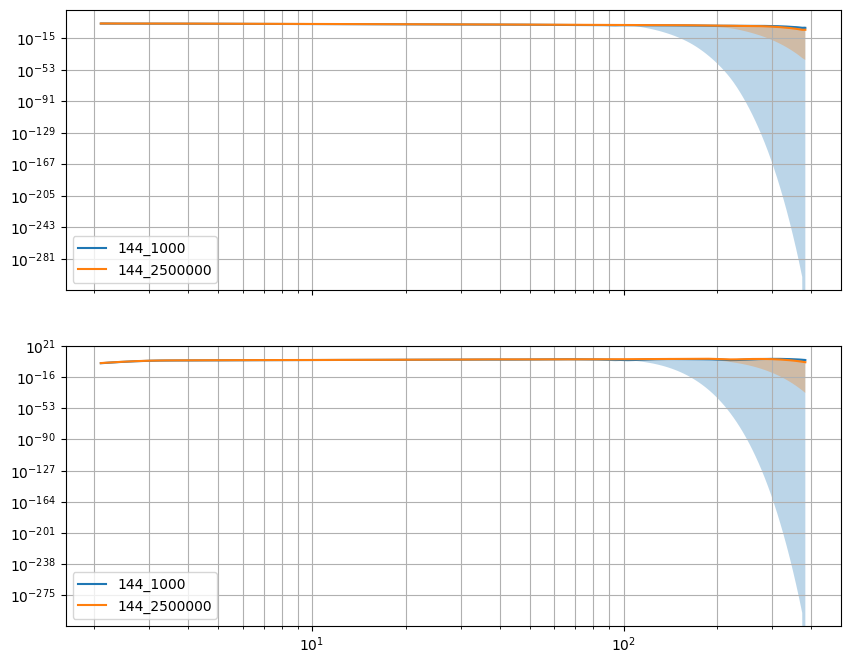

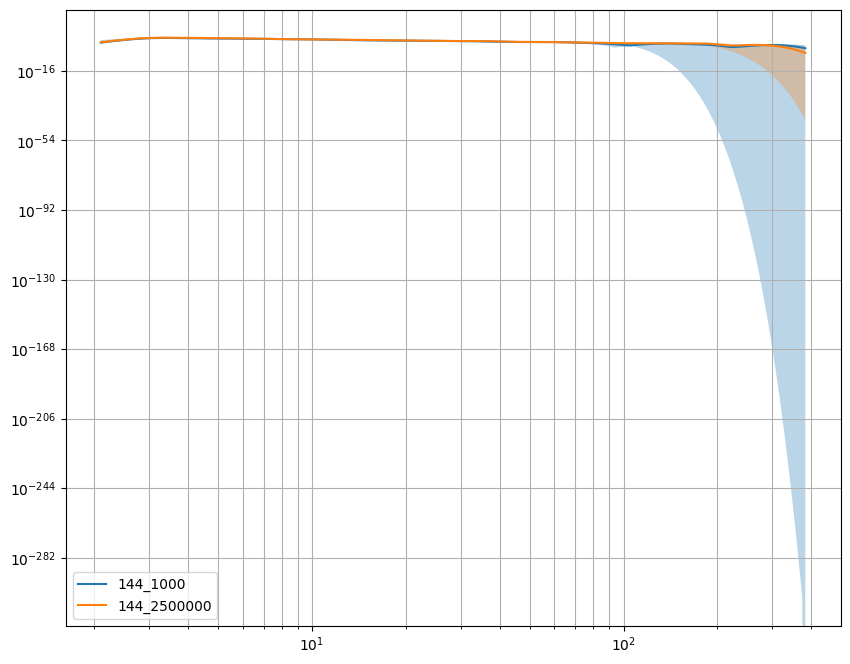

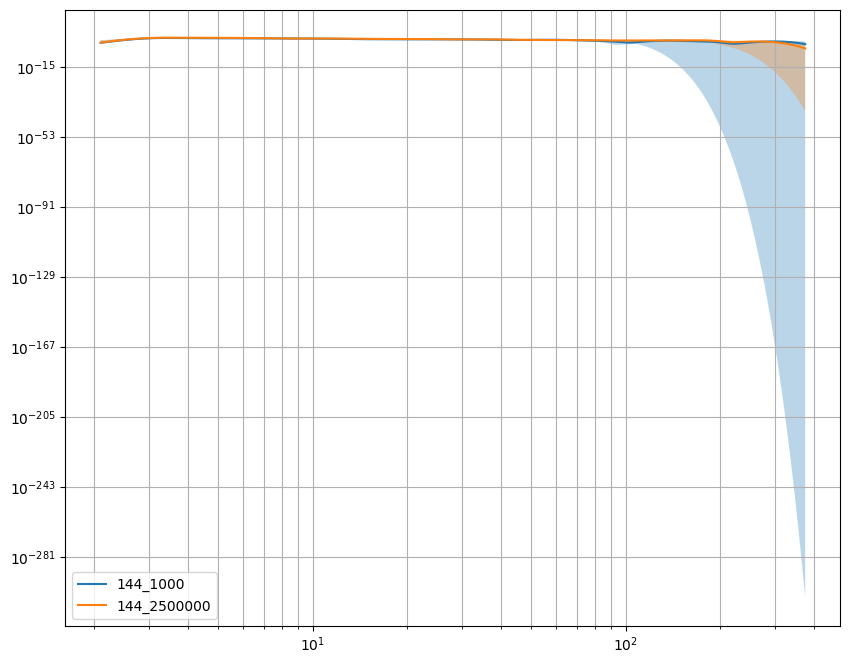

In [95]:
simulation_ids = [144]
nstats = [int(1e3), int(2.5e6)]
first_sim_id = simulation_ids[0]
study_region_size = configs_dict[first_sim_id]["study_region_size"]
study_region_padding = configs_dict[first_sim_id]["study_region_padding"]

# datasets = dict()
# for simulation_id in simulation_ids:
#     states = get_states(
#         stats_df=stats_df,
#         craters_df=craters_df,
#         removals_df=removals_df,
#         nstats=nstats,
#         study_region_size=study_region_size,
#         study_region_padding=study_region_padding,
#         spark=spark,
#         result_columns=["crater_id", "radius", "nstat"],
#     )
#     for nstat in nstats:
#         datasets[f"{simulation_id}_{nstat}"] = states[states.nstat == nstat].radius.sort_values(ascending=False)

grid, sfds, confs = process_datasets(datasets, n_bootstrap=1000, n_jobs=24)
figures = plot_sfds_multi(grid, sfds, confs, figsize=(10, 8))

,crater_id,radius,nstat
0,149,12.301290,100
1,192,9.605181,100
2,303,5.112739,100
3,379,12.708653,100
4,415,4.813532,100
...,...,...,...
1142,121453,41.574895,10000
1143,125025,3.470390,10000
1144,125898,9.521088,10000
1145,127847,5.838006,10000


In [84]:
sfds

{'144_1000': {'dsfd': array([1.22030215e-011, 2.01640031e-011, 3.35232513e-011, 5.60680657e-011,
         9.43231007e-011, 1.59580239e-010, 2.71466511e-010, 4.64235863e-010,
         7.97896744e-010, 1.37794285e-009, 2.39041481e-009, 4.16431419e-009,
         7.28285160e-009, 1.27818936e-008, 2.25040403e-008, 3.97301604e-008,
         7.03046605e-008, 1.24637048e-007, 2.21253328e-007, 3.93076291e-007,
         6.98484331e-007, 1.24068219e-006, 2.20141480e-006, 3.89919883e-006,
         6.88900180e-006, 1.21310849e-005, 2.12735222e-005, 3.71182765e-005,
         6.43775728e-005, 1.10878262e-004, 1.89437584e-004, 3.20710032e-004,
         5.37377943e-004, 8.90097574e-004, 1.45556285e-003, 2.34682588e-003,
         3.72550485e-003, 5.81459896e-003, 8.90924958e-003, 1.33810123e-002,
         1.96693810e-002, 2.82531631e-002, 3.95949690e-002, 5.40558460e-002,
         7.17848690e-002, 9.25999132e-002, 1.15888332e-001, 1.40564806e-001,
         1.65121855e-001, 1.87791472e-001, 2.06804673e-0